# Data Preparation

In [18]:
# %pip install -q matplotlib 
# %pip install -q seaborn
# %pip install -q pandas
# %pip install -q numpy

In [19]:
import matplotlib.pyplot as plt 
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import os 

In [20]:
png_dir = "graphs"
json_dir = "fio_results"
readme_images = []

bs_map = {
    '4K':4096,
    '16K':16384,
    '1M':1048576,
    '2M':2097152,
    '4M':4194304 
}
bs_order = [
    '4K',
    '16K',
    '1M',
    '2M',
    '4M' 
]

rw_map = {
    'read-':'Sequential Read-only',
    'rw-80':'Sequential Read-heavy 4:1',
    'rw-':'Sequential Balanced 1:1',
    'rw-20':'Sequential Write-heavy 1:4',
    'write-':'Sequential Write-only',
    'randread-':'Random Read-only',
    'randrw-80':'Random Read-heavy 4:1',
    'randrw-':'Random Balanced 1:1',
    'randrw-20':'Random Write-heavy 1:4',
    'randwrite-':'Random Write-only'
}
# wanted to use this dict to label lines.. 
marker_dict = {
    'Sequential Read-only':'SR',
    'Sequential Read-heavy 4:1':'SRH',
    'Sequential Balanced 1:1':'SB',
    'Sequential Write-heavy 1:4':'SWH',
    'Sequential Write-only':'SW',
    'Random Read-only':'RR',
    'Random Read-heavy 4:1':'RRH',
    'Random Balanced 1:1':'RB',
    'Random Write-heavy 1:4':'RWH',
    'Random Write-only':'RW'
}
hue_order = ['Sequential Read-only','Sequential Read-heavy 4:1','Sequential Balanced 1:1','Sequential Write-heavy 1:4','Sequential Write-only','Random Read-only','Random Read-heavy 4:1','Random Balanced 1:1','Random Write-heavy 1:4','Random Write-only']
sequential_full = ['Sequential Read-only','Sequential Read-heavy 4:1','Sequential Balanced 1:1','Sequential Write-heavy 1:4','Sequential Write-only']
random_full = ['Random Read-only','Random Read-heavy 4:1','Random Balanced 1:1','Random Write-heavy 1:4','Random Write-only']

sns.set_style("whitegrid")
# palette = sns.color_palette("magma", 10) 
palette = sns.color_palette("flare", 5) + sns.color_palette("crest", 5)

# parameters to display in this notebook
# just to view an example graph from looped graph generations and to avoid crowded notebook
DISPLAY_BS = '2M'
DISPLAY_NJ = 16
DISPLAY_IOD = 1

In [21]:
# Assemble columns names
rwfile = 'fio_rw_json_example.json'
mixfile = 'fio_mix_json_example.json'
cols = pd.json_normalize(pd.read_json(rwfile)['jobs']).columns.tolist() + pd.json_normalize(pd.read_json(mixfile)['jobs']).columns.tolist() 
cols = list(set(cols))


# Read in json files
first = True
df = pd.DataFrame()
frames = []
for file_name in os.listdir(json_dir):
    if file_name.endswith('.json'): 
        file = os.path.join(json_dir, file_name)
        # print(file_name)
    
        tmp = pd.json_normalize(pd.read_json(file)['jobs'])
        # tmp = tmp.reindex(columns=cols)
    
        for col in tmp.select_dtypes(include=['int', 'int64', 'int32']).columns:
            tmp[col] = tmp[col].astype(float)
    
        frames.append(tmp)
        # if first:
        #     df = tmp
        #     first = False
        # else:
        #     # df = pd.merge(tmp, df, how="outer", on=cols)
        #     df = pd.concat([tmp, df], ignore_index=True)
df = pd.concat(frames, ignore_index=True)
df = df.copy()

#### COLUMN NAMES ####
#####   Variables:  
# "job options.iodepth" : io depth
# "job options.numjobs" : number of jobs
# "job options.bs" : block size
# "rw_full" : read write type (human readable)
#
#####   Outputs:    
# "bw_mean" : mean bandwidth
# "iops" : iops
# "lat_ns.mean" : mean latency
# "lat_ns.percentile.99.000000" : 99% latency
######################


# with open("df.txt", 'a') as f:
#     f.write(df.to_string())
df.to_csv("fio_results.csv")


In [22]:
# Set up columns and data types

# Read-Write
df['rw_code'] = df['job options.rw'].str.cat(df['job options.rwmixread'], sep='-', na_rep='')
df["rw_full"] = df["rw_code"].map(rw_map)

# Block Size 
df['bs_num'] = df['job options.bs'].map(bs_map)
df['bs_num'] = df['bs_num'].astype(int)

# Number of Jobs
df["job options.numjobs"] = df["job options.numjobs"].astype(int)

# IO Depth
df["job options.iodepth"] = df["job options.iodepth"].astype(int)

def rand_or_seq(rw_full):
    if rw_full in random_full:
        return 'random'
    elif rw_full in sequential_full:
        return 'sequential'
    else:
        return -1
df['rand_seq_type'] = df['rw_full'].apply(rand_or_seq)

# Helper function to combine mixes/read/write outputs into one column for plotting
def get_var(row, colname):
    var_cols = ['mixed.'+colname, 'read.'+colname, 'write.'+colname]
    for col in var_cols:
        if col in row.index:
            var = row[col]
            if pd.notna(var) and var != 0:
                return var, col
    return np.nan, None

# Bandwidth
df['bw_mean']  = df.apply(lambda row: get_var(row, 'bw_mean')[0], axis=1)
df['bw_mean'] = df['bw_mean']/(1024*1024)

# Iops
df['iops'] = df.apply(lambda row: get_var(row, 'iops')[0], axis=1)
df['iops'] = df['iops'].astype(int)

# Latency
df['lat_ns.mean'] = df.apply(lambda row: get_var(row, 'lat_ns.mean')[0], axis=1)
df['lat_s.mean'] = df['lat_ns.mean']/1e9
df['lat_ns.percentile.99.000000'] = df.apply(lambda row: get_var(row, 'lat_ns.percentile.99.000000')[0], axis=1)
df['lat_s.percentile.99.000000'] = df['lat_ns.percentile.99.000000']/1e9


# Minimums and Maximums

In [ ]:
# Get diagnostics over entire dataset
maxes = df.idxmax(numeric_only=True)
mins = df.idxmin(numeric_only=True)

# Index of max bandwidth
# print(maxes['bw_mean'])
# print(df.iloc[maxes['bw_mean']])
print(f'Maximum Bandwidth: {max(df['bw_mean'])} GiB/s when \n\tIO Depth = {df.iloc[maxes['bw_mean']]["job options.iodepth"]}, \n\t# Jobs = {df.iloc[maxes['bw_mean']]["job options.numjobs"]}, \n\tBlock Size = {df.iloc[maxes['bw_mean']]["job options.bs"]}, \n\tRead/Write Type = {df.iloc[maxes['bw_mean']]["rw_full"]}')
print('\n')
print(f'Maximum IOPS: {max(df['iops'])} when \n\tIO Depth = {df.iloc[maxes['iops']]["job options.iodepth"]}, \n\t# Jobs = {df.iloc[maxes['iops']]["job options.numjobs"]}, \n\tBlock Size = {df.iloc[maxes['iops']]["job options.bs"]}, \n\tRead/Write Type = {df.iloc[maxes['iops']]["rw_full"]}')
print('\n')
# Index of min latency
# print(mins['lat_ns.mean'])
# print(df.iloc[mins['lat_ns.mean']])

print(f'Minimum Latency (mean): {min(df['lat_ns.mean'])/1e9} s ({min(df['lat_ns.mean'])} ns) when \n\tIO Depth = {df.iloc[mins['lat_ns.mean']]["job options.iodepth"]}, \n\t# Jobs = {df.iloc[mins['lat_ns.mean']]["job options.numjobs"]}, \n\tBlock Size = {df.iloc[mins['lat_ns.mean']]["job options.bs"]}, \n\tRead/Write Type = {df.iloc[mins['lat_ns.mean']]["rw_full"]}')
print('\n')
print(f'Minimum Latency (99 percentile): {min(df['lat_ns.percentile.99.000000'])/1e9} s ({min(df['lat_ns.percentile.99.000000'])} ns) when \n\tIO Depth = {df.iloc[mins['lat_ns.percentile.99.000000']]["job options.iodepth"]}, \n\t# Jobs = {df.iloc[mins['lat_ns.percentile.99.000000']]["job options.numjobs"]}, \n\tBlock Size = {df.iloc[mins['lat_ns.percentile.99.000000']]["job options.bs"]}, \n\tRead/Write Type = {df.iloc[mins['lat_ns.percentile.99.000000']]["rw_full"]}')

print(f'\nChecking for incomplete runs....\n{df[df['elapsed'] < 60]}')

Maximum Bandwidth: 14.4631638258152 GiB/s when 
	IO Depth = 64, 
	# Jobs = 128, 
	Block Size = 2M, 
	Read/Write Type = Sequential Write-only


Maximum IOPS: 80284 when 
	IO Depth = 8, 
	# Jobs = 32, 
	Block Size = 16K, 
	Read/Write Type = Random Write-only


Minimum Latency (mean): 0.000218020866563 s (218020.866563 ns) when 
	IO Depth = 32, 
	# Jobs = 16, 
	Block Size = 4K, 
	Read/Write Type = Sequential Write-only


Minimum Latency (99 percentile): 0.000321536 s (321536.0 ns) when 
	IO Depth = 32, 
	# Jobs = 16, 
	Block Size = 4K, 
	Read/Write Type = Sequential Write-only

Checking for incomplete runs....
Minimum elapsed time is 34.0
 at               jobname  groupid  error  eta  elapsed  job_runtime   usr_cpu  \
150  RandWH-2M-128-32      0.0  107.0  0.0     34.0    4111710.0  1.066272   
777    SeqW-2M-128-64      0.0  107.0  0.0     52.0    6453675.0  3.477027   

      sys_cpu       ctx  majf  ...    rw_code                 rw_full  \
150  0.156772  206144.0   4.0  ...  randrw-2

# Bandwidth Plots

## Bandwidth vs Number of Jobs

/tmp/ipykernel_79464/3425070089.py:6: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  g = sns.relplot(data=df,


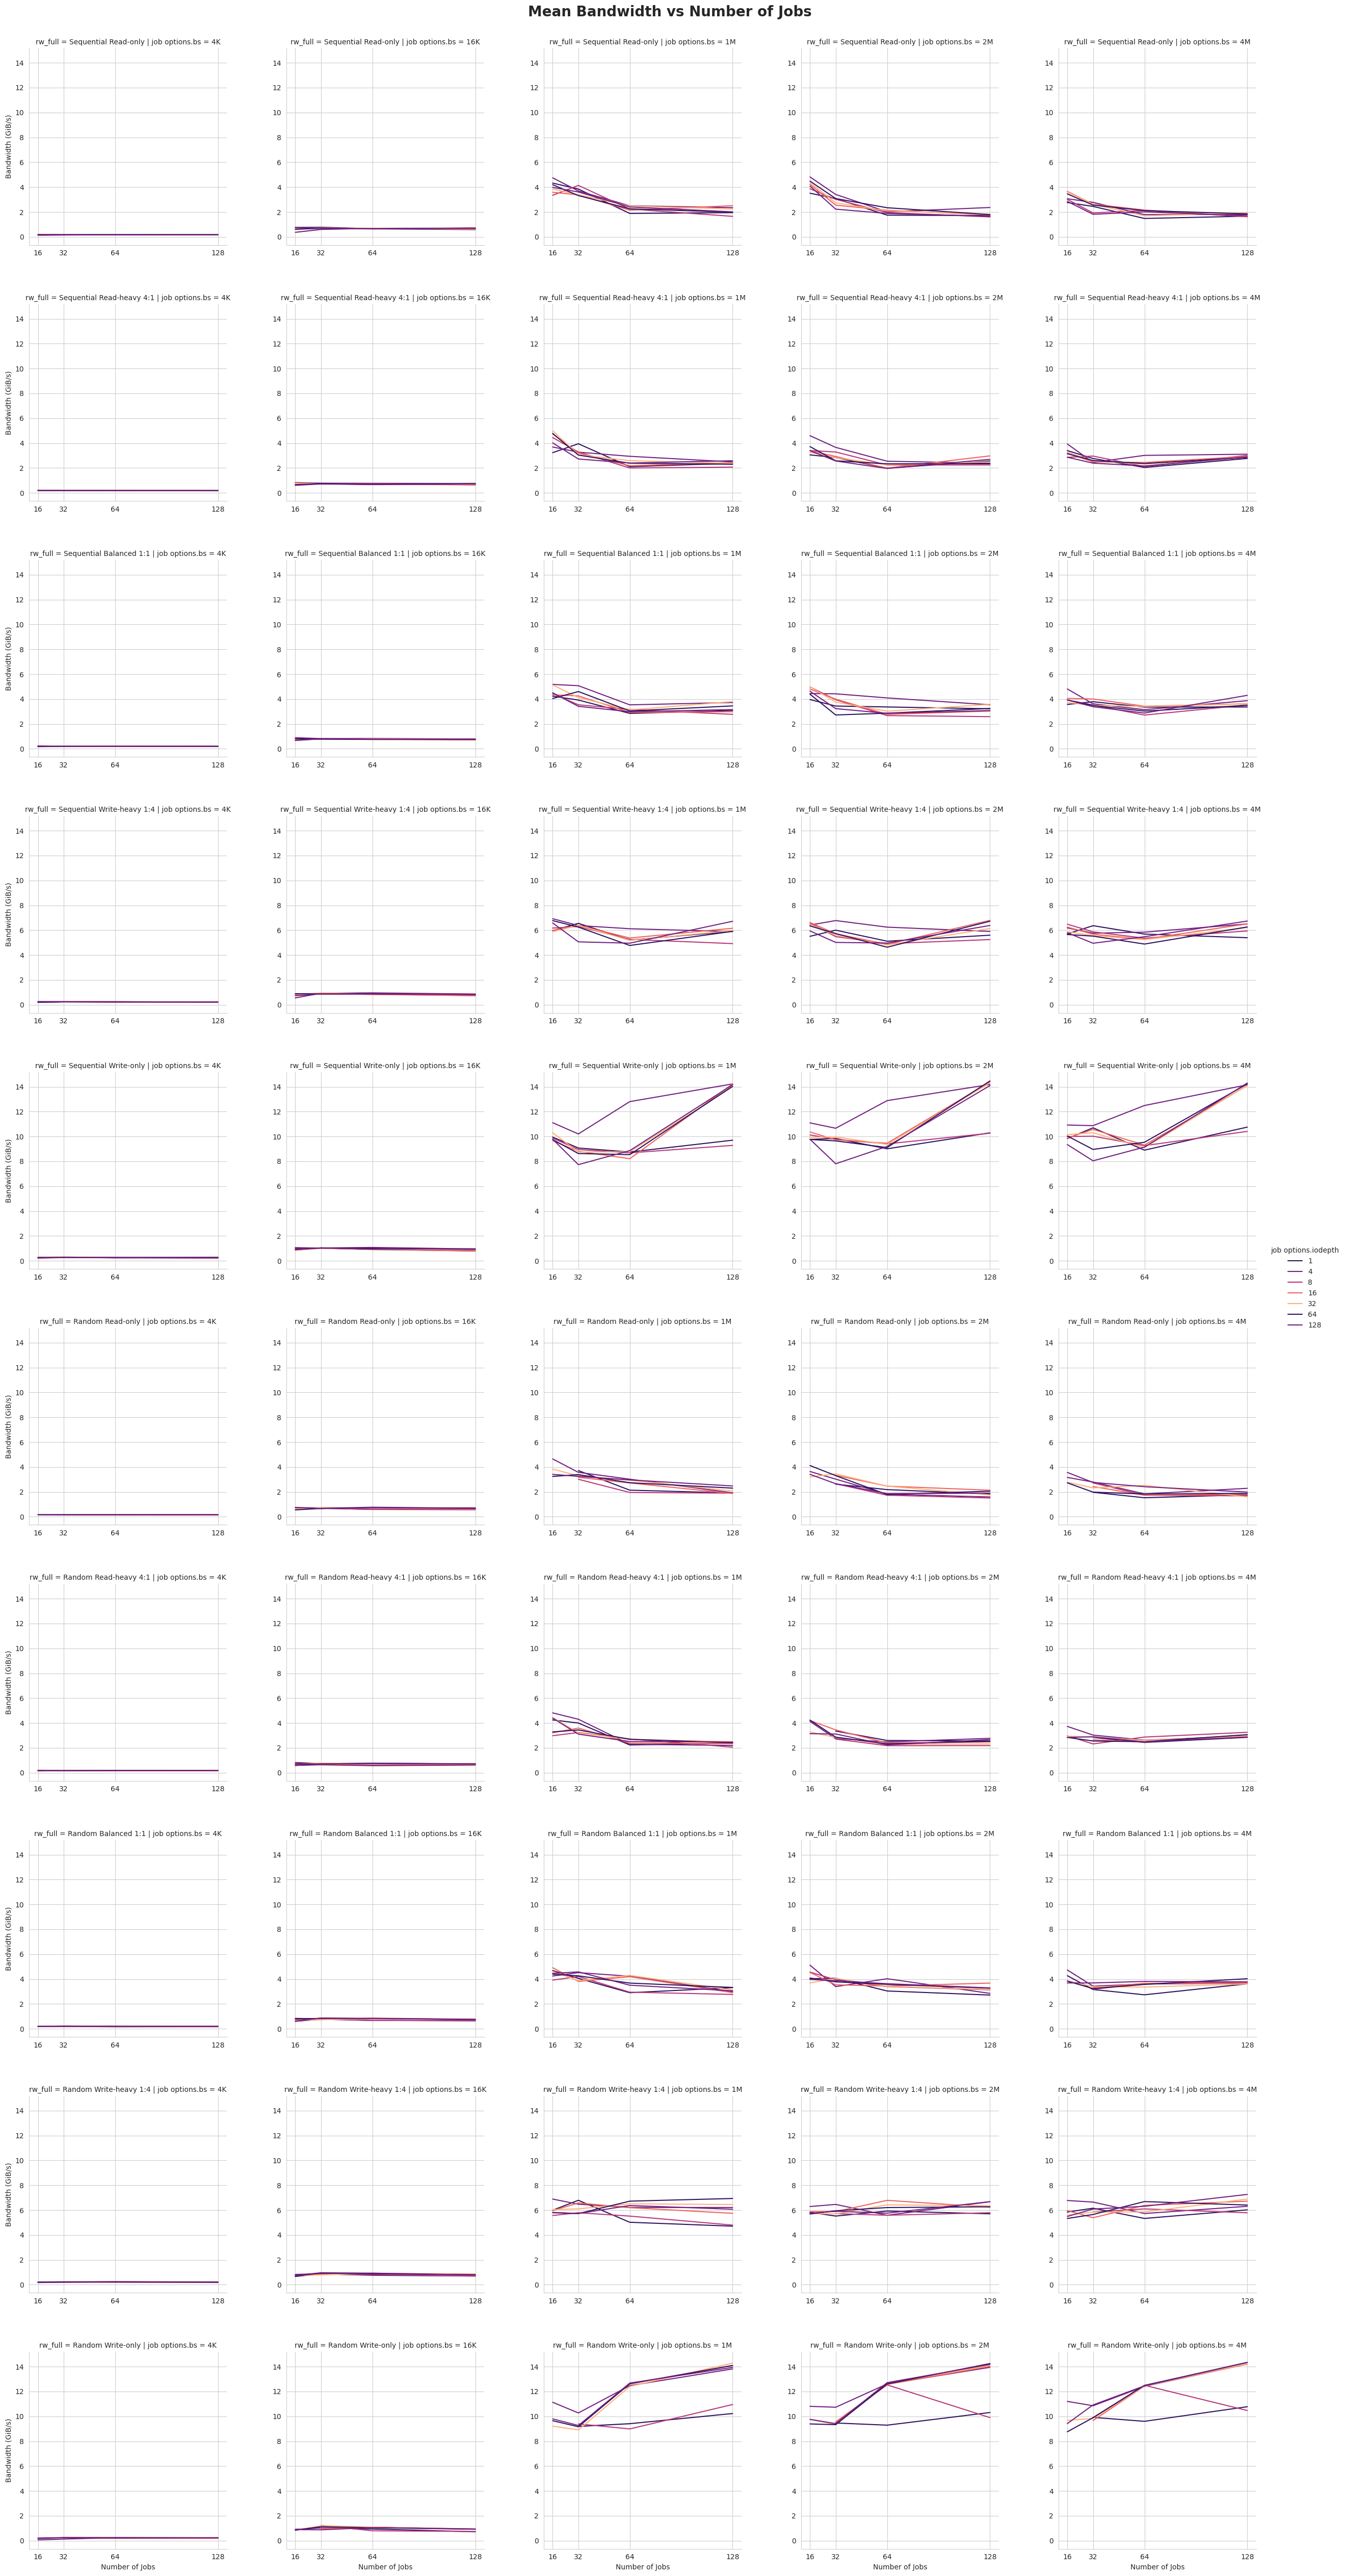

<Figure size 640x480 with 0 Axes>

In [24]:
# BANDWIDTH vs NUMBER OF JOBS FACET GRID
palette = sns.color_palette("magma", 5) + sns.color_palette("magma", 5)

# seq_writes = df[df["rw_full"]=='Sequential Write-only']

g = sns.relplot(data=df,
                kind="line",
                x="job options.numjobs",
                hue="job options.iodepth", 
                y="bw_mean",
                col="job options.bs",
                row="rw_full",
                palette=palette,
                col_order=bs_order,
                row_order=hue_order
                )

g.set_ylabels("Bandwidth (GiB/s)")
g.set_xlabels("Number of Jobs")
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
g.figure.suptitle("Mean Bandwidth vs Number of Jobs", fontsize=20, weight="bold", x = 0.5, y=1.01)
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks(df["job options.numjobs"].unique())
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )

plt.savefig((png_dir + "/fio_bandwidth/fio_bw_vs_nj_hueIOD_allD.svg"), bbox_inches="tight")
plt.show()
plt.clf()

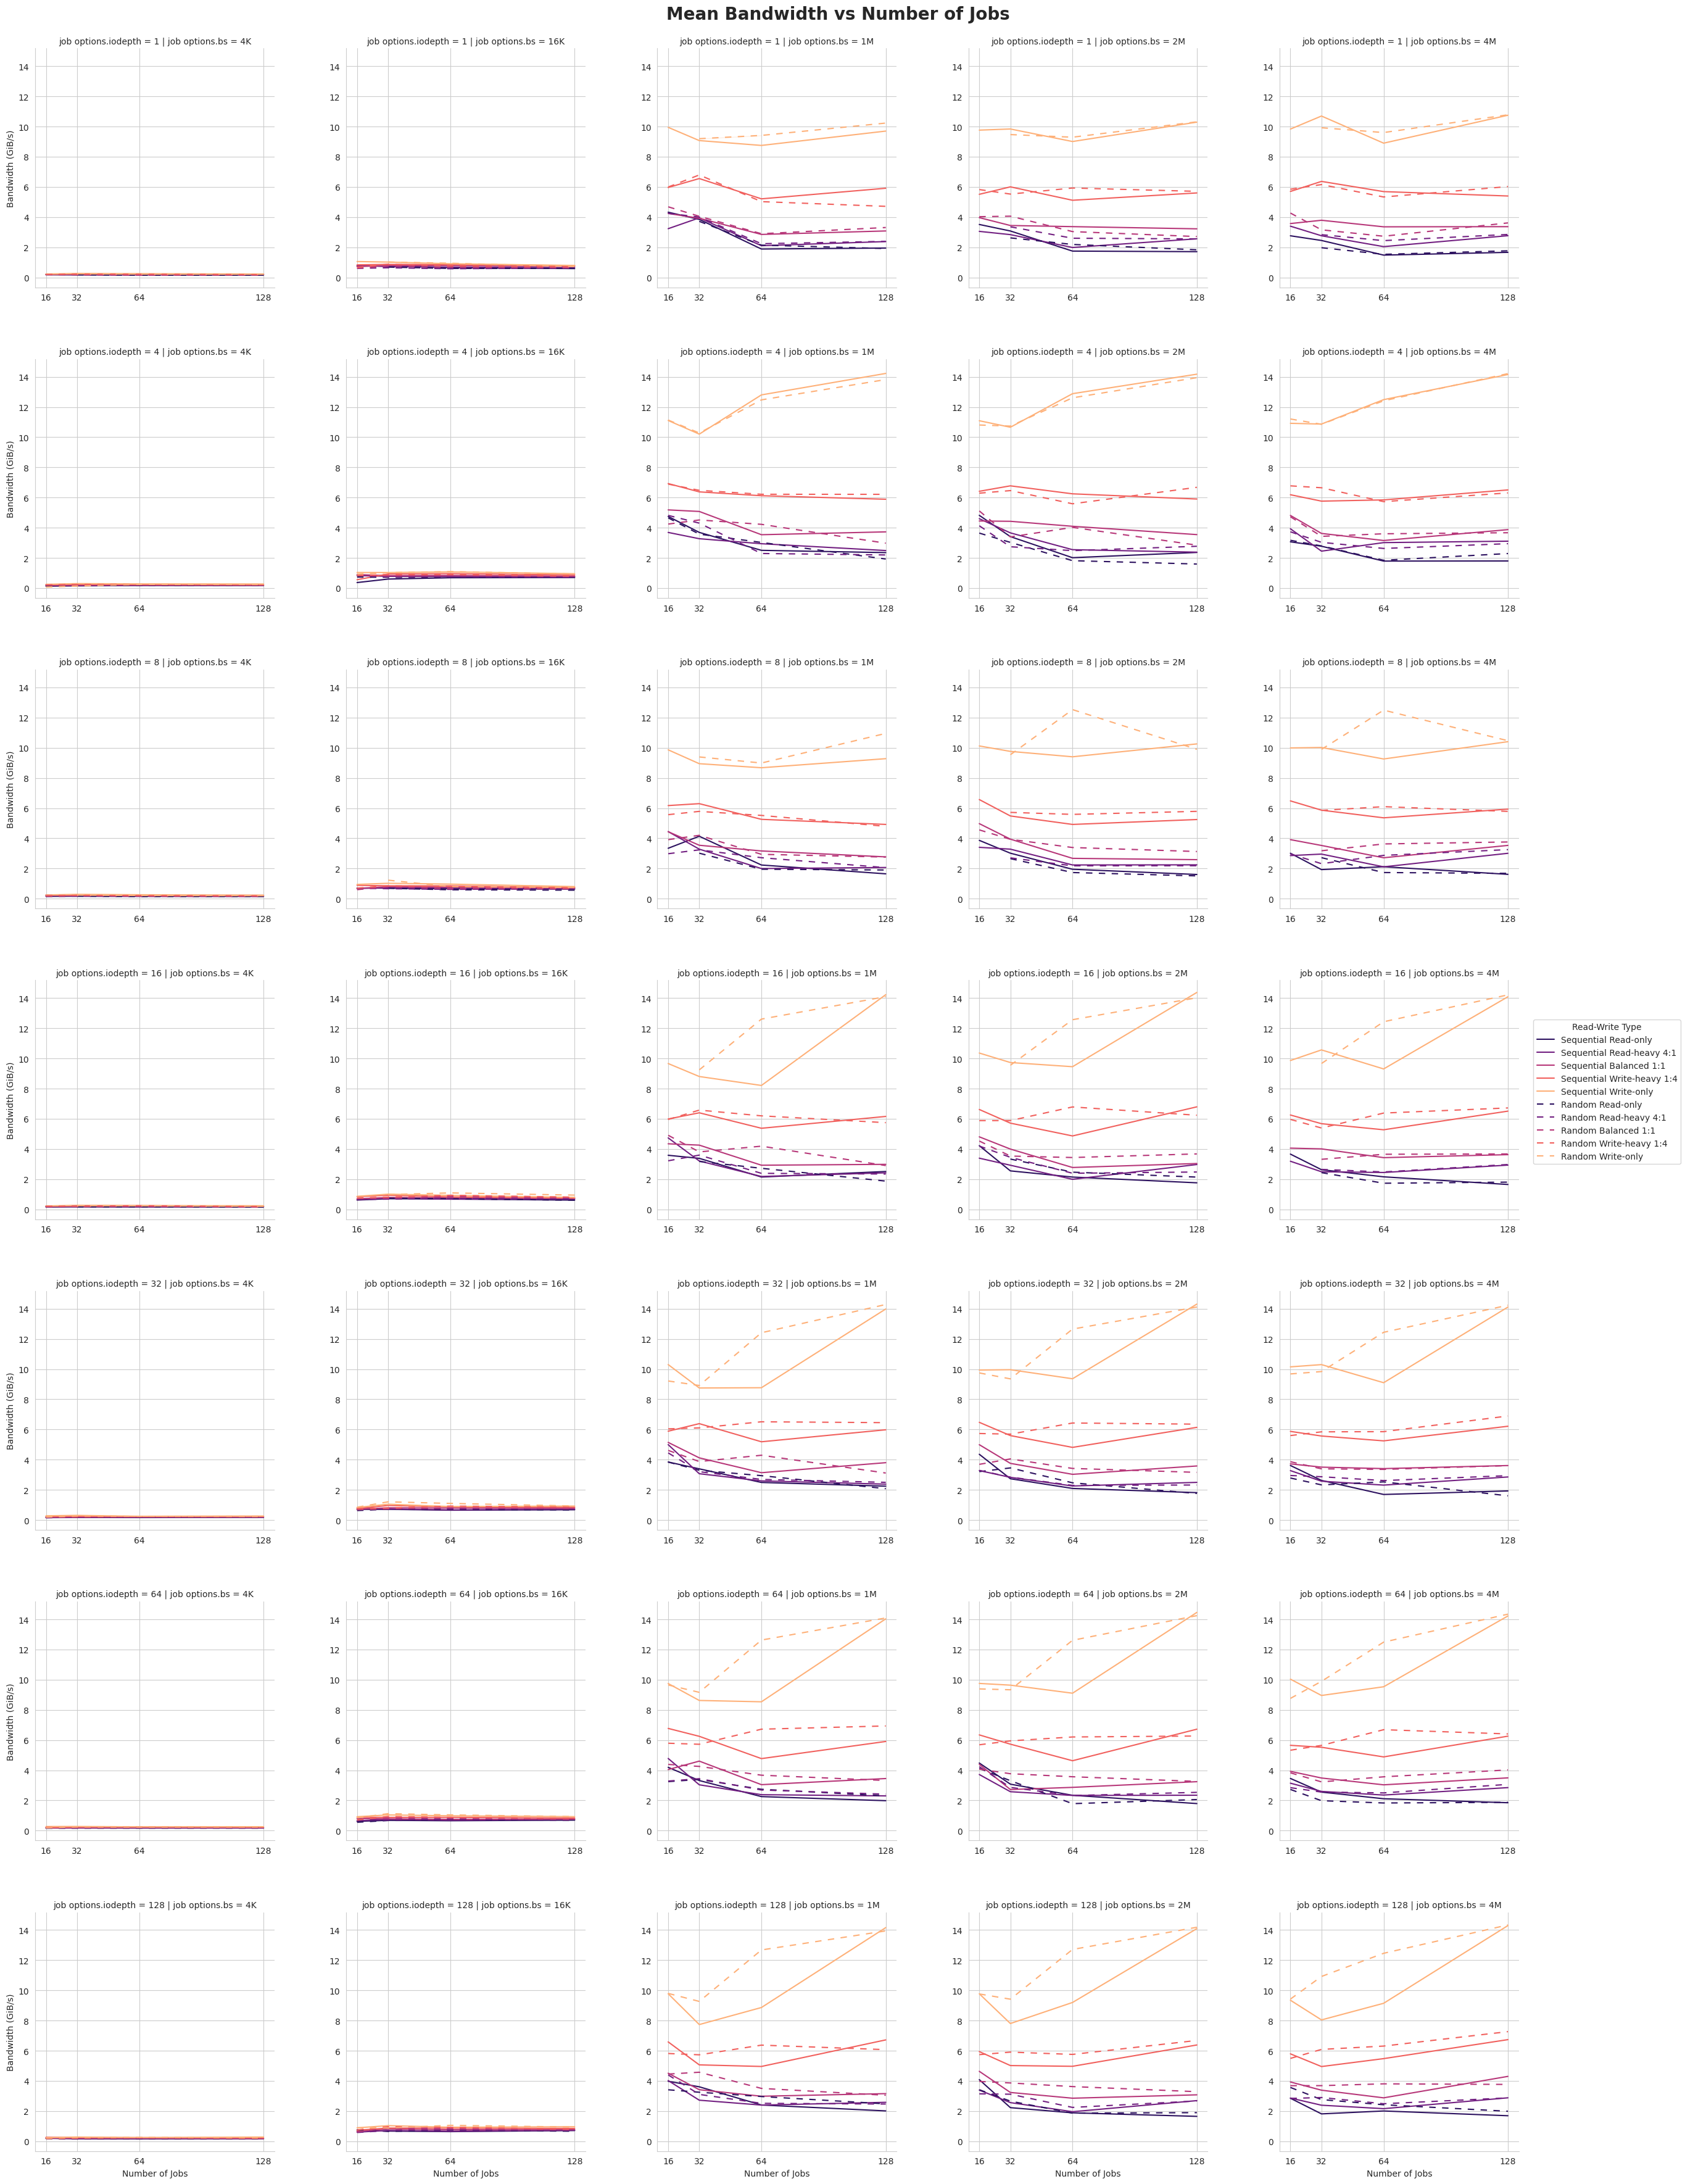

<Figure size 640x480 with 0 Axes>

In [25]:
# BANDWIDTH vs NUMBER OF JOBS FACET GRID
palette = sns.color_palette("magma", 5) + sns.color_palette("magma", 5)

dashes = {'sequential': '', 'random': (5, 5) }

g = sns.relplot(data=df,
                kind="line",
                x="job options.numjobs",
                hue="rw_full", 
                y="bw_mean",
                row="job options.iodepth",
                col="job options.bs",
                style="rand_seq_type",
                dashes=dashes,
                palette=palette,
                hue_order=hue_order,
                col_order=bs_order,
                )

g.set_ylabels("Bandwidth (GiB/s)")
g.set_xlabels("Number of Jobs")
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
g.figure.suptitle("Mean Bandwidth vs Number of Jobs", fontsize=20, weight="bold", x = 0.5, y=1.01)
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks(df["job options.numjobs"].unique())
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )

lines =  g.axes.flat[0] .get_lines()
lines = [l for l in lines if len(l.get_ydata()) > 0] 

g._legend.remove()
g.figure.legend(
    handles=lines,
    labels=hue_order, 
    title='Read-Write Type',
    loc='center right'
)

plt.savefig((png_dir + "/fio_bandwidth/fio_bw_vs_nj_hueRW_allD.svg"), bbox_inches="tight")
plt.show()
plt.clf()

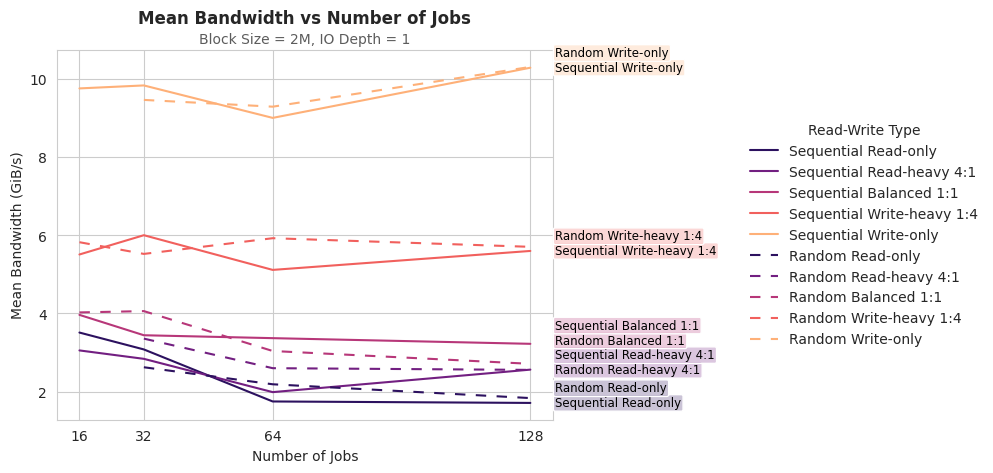

KeyboardInterrupt: 

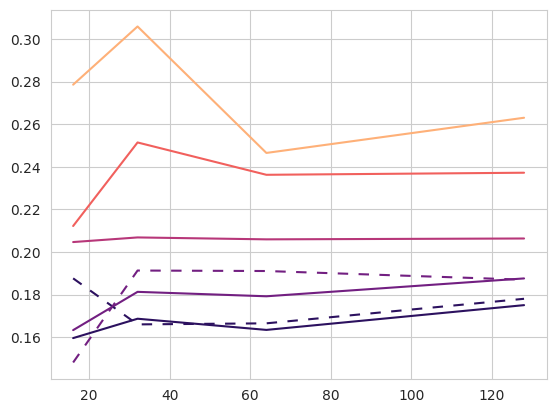

In [26]:
# BANDWIDTH vs Number of Jobs
palette = sns.color_palette("magma", 5) + sns.color_palette("magma", 5)
for iod in df["job options.iodepth"].unique():
    for bs in df["job options.bs"].unique():
        subdf = df[ (df["job options.iodepth"] == iod) & (df["job options.bs"] == bs) ]
        rows, cols = subdf.shape
        if rows >0:
            dashes = {
                'sequential': '',  # solid
                'random': (5, 5)  # dashed
            }
            ax = sns.lineplot(
                data=subdf,
                x="job options.numjobs",
                y="bw_mean",
                hue="rw_full", 
                style="rand_seq_type", dashes=dashes,
                # marker='o',
                hue_order=hue_order,
                # order=bs_order,
                palette=palette
            )
            ax.set_xticks(subdf["job options.numjobs"].unique())
            ax.set_xlabel("Number of Jobs")
            ax.set_ylabel("Mean Bandwidth (GiB/s)")
            ax.set_title("Mean Bandwidth vs Number of Jobs", weight="bold", x=0.5, y=1.05)

            ax.text(x=0.5, y=1.01, 
                    s=f"Block Size = {bs}, IO Depth = {iod}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)
            ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', loc="upper left")

            # get lines and labels
            lines = ax.get_lines()
            lines = [l for l in lines if len(l.get_ydata())>0]

            handles, labels = ax.get_legend_handles_labels()
            labels = [label for label in labels if label in subdf['rw_full'].unique().tolist() ]

            end_points = sorted(
                [(h.get_ydata()[-1], h, l) for h, l in zip(lines, labels)],
                key=lambda tup: tup[0]
            )
            # set positions of labels
            y_positions = []
            min_gap = 0.04 * (ax.get_ylim()[1] - ax.get_ylim()[0]) 

            x_pos = 0
            y_pos = 0
            for line in lines:
                x_pos = max(x_pos, line.get_xdata()[-1] + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]))

            for i, (y, line, label) in enumerate(end_points):
                if i == 0:
                    y_pos = y
                else:
                    y_pos = max( y, y_positions[-1] + min_gap )
                # if i < 5:
                #     y_pos -= 0.1
                y_positions.append(y_pos)

                # highlighted lables
                stroke_color = mcolors.to_rgba(line.get_color(), alpha=0.25)
                ax.text(x_pos, y_pos, label, color='black',
                        bbox=dict( boxstyle='round,pad=0.15', facecolor=stroke_color),
                        va='center', fontsize=8.5)
                
            legend_x = x_pos + 0.4*(ax.get_xlim()[1] - ax.get_xlim()[0]) 
            legend_y = 0.5  

            ax.legend(
                loc='center left',
                labels=hue_order,
                handles=lines,
                bbox_to_anchor=(legend_x / ax.get_xlim()[1], legend_y),  
                title='Read-Write Type',
                frameon=False
            )

            # ax.legend_.remove()
            # REMOVE IF STATEMENT TO SEE AND SAVE ALL
            if (bs==DISPLAY_BS and iod==DISPLAY_IOD):
                plt.savefig((png_dir + f"/fio_bandwidth/fio_bw_vs_nj_iod-{iod}_bs-{bs}.svg"), bbox_inches="tight")
                plt.show()
            plt.clf()

## Bandwidth vs IO Depth

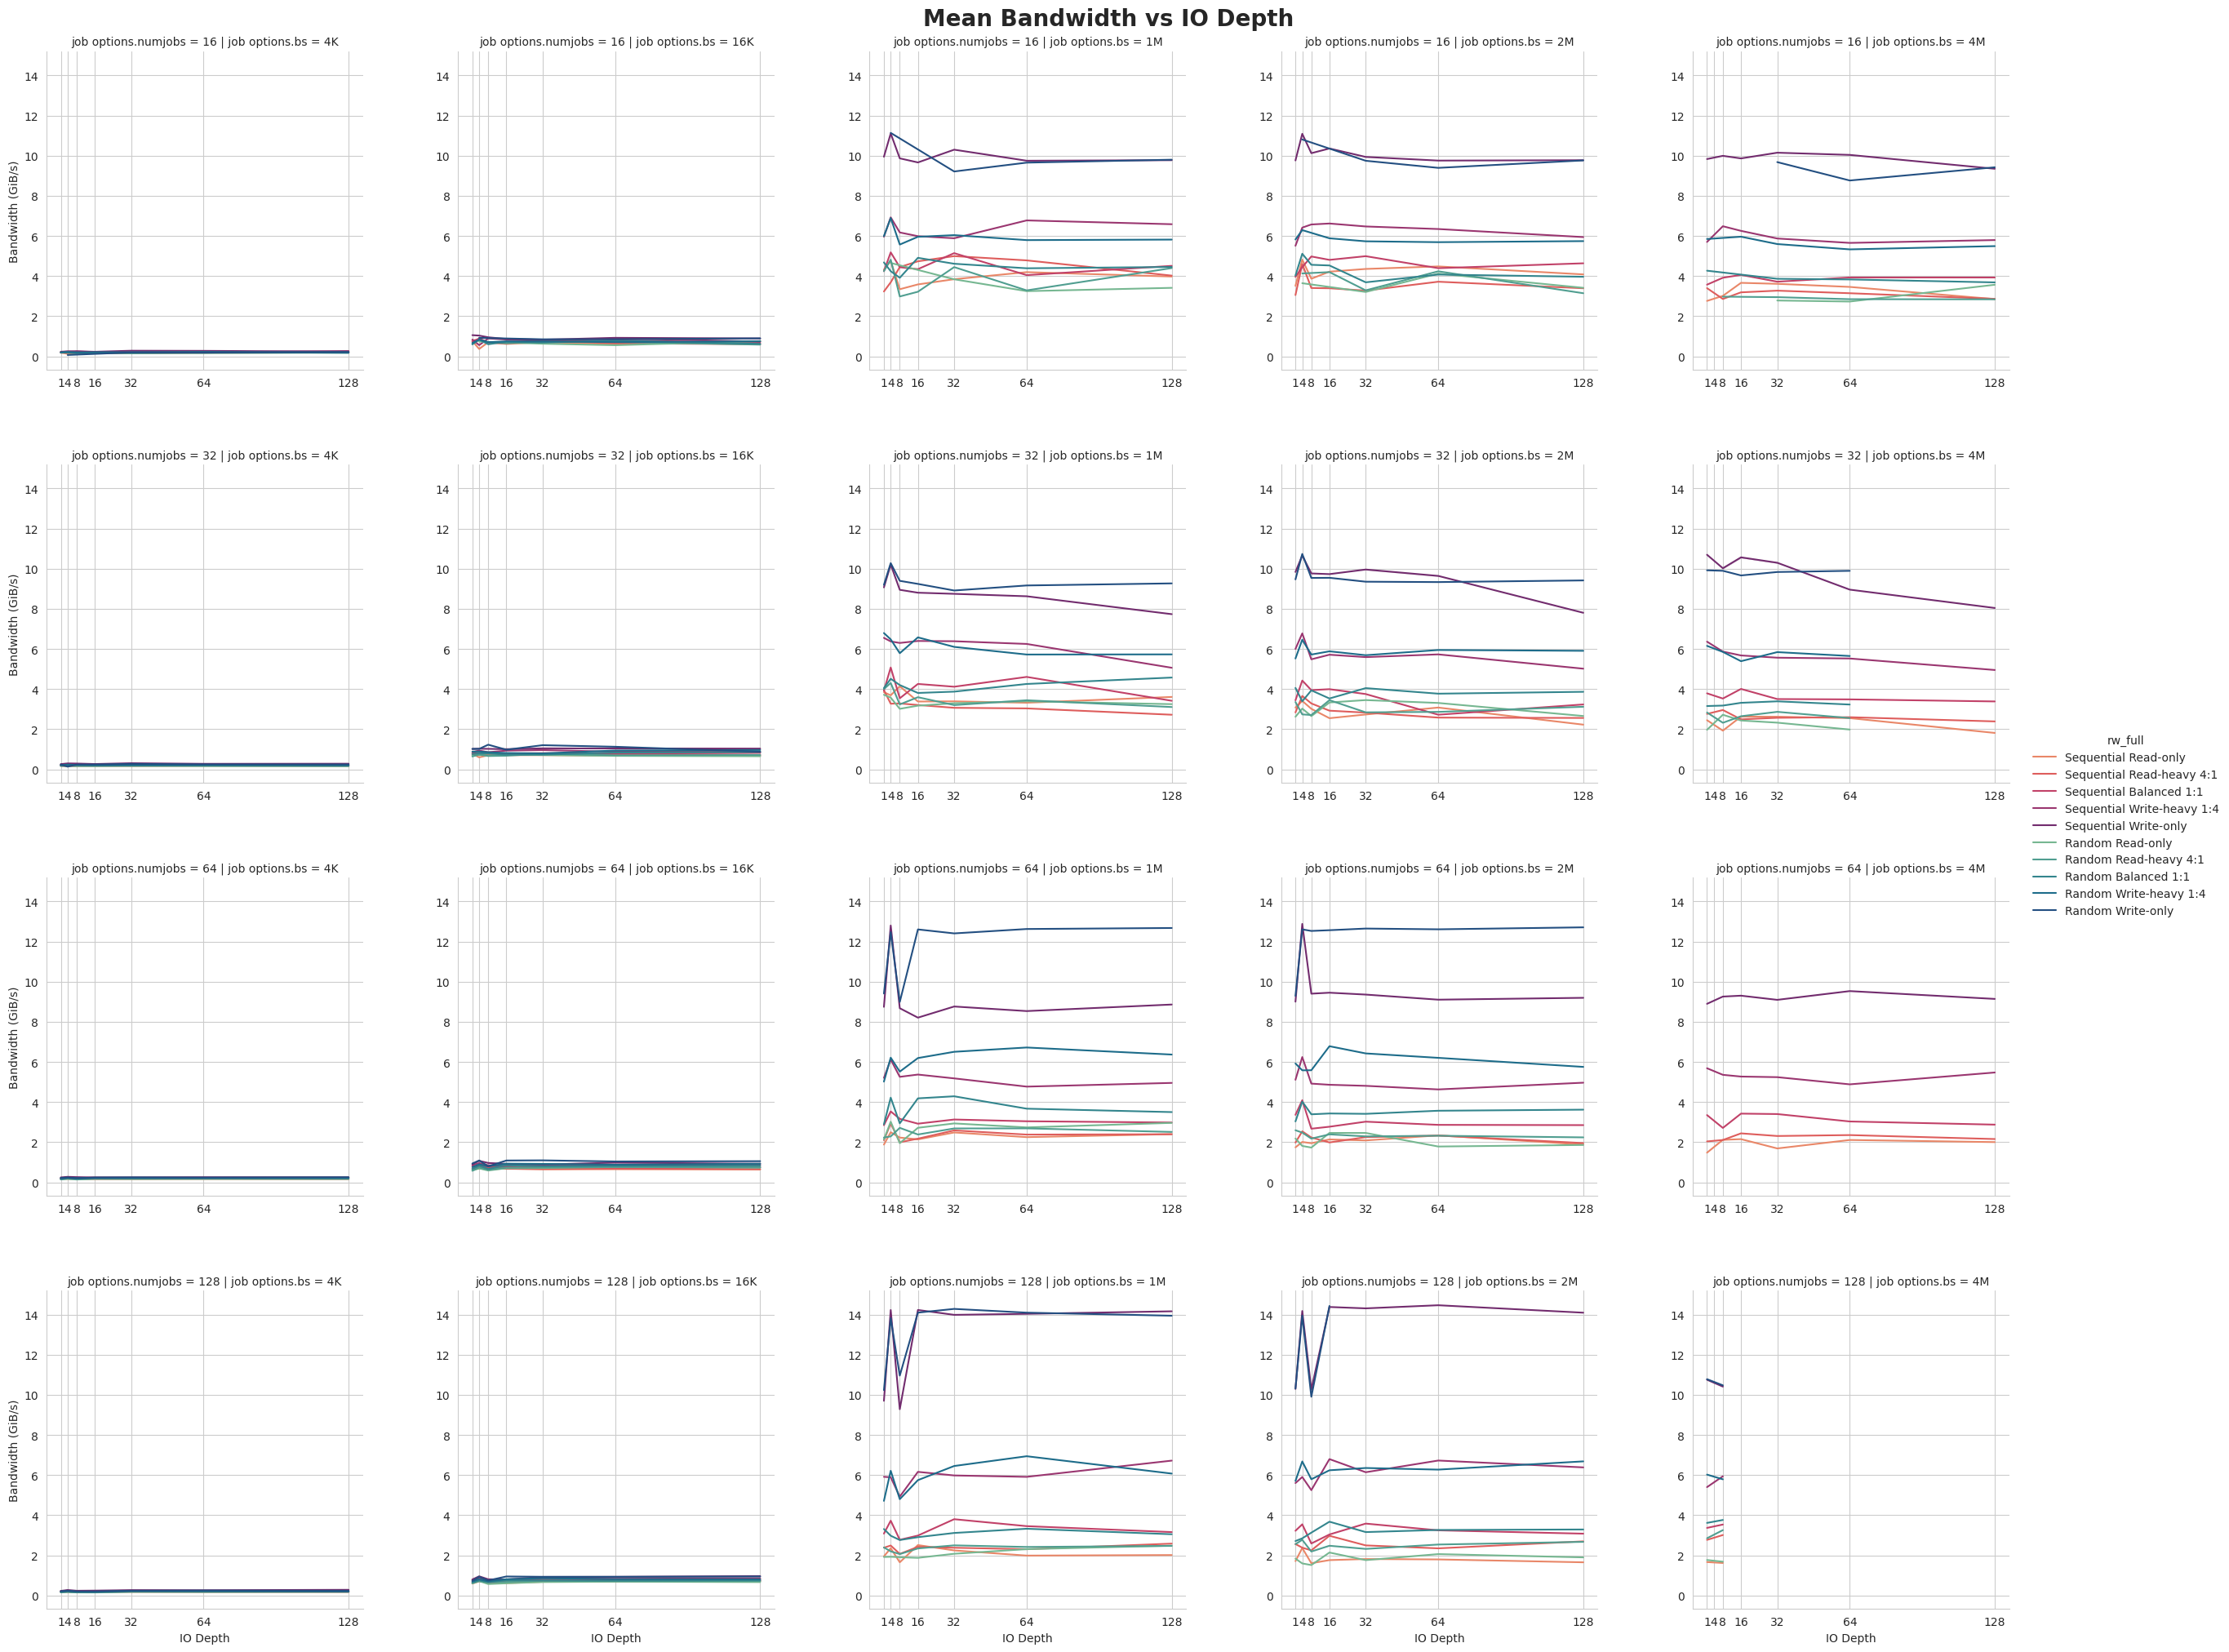

<Figure size 640x480 with 0 Axes>

In [ ]:
# BANDWIDTH vs IO DEPTH FACET GRID
palette = sns.color_palette("flare", 5) + sns.color_palette("crest", 5)

dashes = {'sequential': '', 'random': (5, 5) }

g = sns.relplot(data=df,
                kind="line",
                x="job options.iodepth",
                hue="rw_full", 
                y="bw_mean",
                row="job options.numjobs",
                col="job options.bs",
                palette=palette,
                # width=5,
                hue_order=hue_order,
                # style='rand_seq_type',
                # dashes=dashes,
                col_order=bs_order,
                # errorbar=None,
                # height=5, aspect=1.5,
                # sharex=True, sharey=True
                )
g.set_ylabels("Bandwidth (GiB/s)")
g.set_xlabels("IO Depth")
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
g.figure.suptitle("Mean Bandwidth vs IO Depth", fontsize=20, weight="bold", x = 0.5, y=1.01)
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks(df["job options.iodepth"].unique())
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )


plt.savefig((png_dir + "/fio_bandwidth/fio_bw_vs_iod_allD.svg"), bbox_inches="tight")
plt.show()
plt.clf()


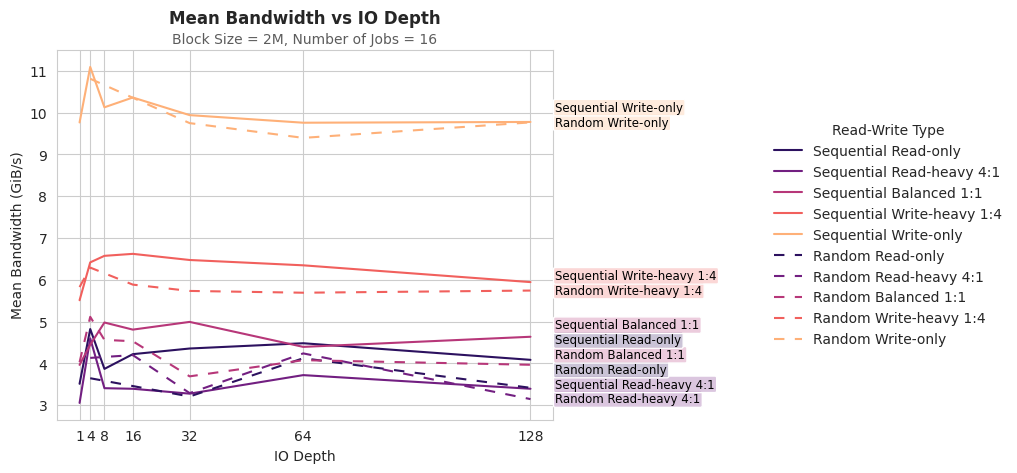

<Figure size 640x480 with 0 Axes>

In [ ]:
# BANDWIDTH vs IO DEPTH
palette = sns.color_palette("magma", 5) + sns.color_palette("magma", 5)
for nj in df["job options.numjobs"].unique():
    for bs in df["job options.bs"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["job options.bs"] == bs) ]
        rows, cols = subdf.shape
        if rows >0:
            dashes = {
                'sequential': '',  # solid
                'random': (5, 5)  # dashed
            }
            ax = sns.lineplot(
                data=subdf,
                x="job options.iodepth",
                y="bw_mean",
                hue="rw_full", 
                style="rand_seq_type", dashes=dashes,
                # marker='o',
                hue_order=hue_order,
                # order=bs_order,
                palette=palette
            )
            ax.set_xticks(subdf["job options.iodepth"].unique())
            ax.set_xlabel("IO Depth")
            ax.set_ylabel("Mean Bandwidth (GiB/s)")
            ax.set_title("Mean Bandwidth vs IO Depth", weight="bold", x=0.5, y=1.05)

            ax.text(x=0.5, y=1.01, 
                    s=f"Block Size = {bs}, Number of Jobs = {nj}", 
                    fontsize=10, alpha=0.75, ha='center', va='bottom', 
                    transform=ax.transAxes)
            ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', loc="upper left")

            # get lines and labels
            lines = ax.get_lines()
            lines = [l for l in lines if len(l.get_ydata())>0]

            handles, labels = ax.get_legend_handles_labels()
            labels = [label for label in labels if label in subdf['rw_full'].unique().tolist() ]

            end_points = sorted(
                [(h.get_ydata()[-1], h, l) for h, l in zip(lines, labels)],
                key=lambda tup: tup[0]
            )
            # set positions of labels
            y_positions = []
            min_gap = 0.04 * (ax.get_ylim()[1] - ax.get_ylim()[0]) 

            x_pos = 0
            y_pos = 0
            for line in lines:
                x_pos = max(x_pos, line.get_xdata()[-1] + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]))

            for i, (y, line, label) in enumerate(end_points):
                if i == 0:
                    y_pos = y
                else:
                    y_pos = max( y, y_positions[-1] + min_gap )
                # if i < 5:
                #     y_pos -= 0.1
                y_positions.append(y_pos)

                # highlighted lables
                stroke_color = mcolors.to_rgba(line.get_color(), alpha=0.25)
                ax.text(x_pos, y_pos, label, color='black',
                        bbox=dict( boxstyle='round,pad=0.15', facecolor=stroke_color),
                        va='center', fontsize=8.5)
                
            legend_x = x_pos + 0.4*(ax.get_xlim()[1] - ax.get_xlim()[0]) 
            legend_y = 0.5  

            ax.legend(
                loc='center left',
                labels=hue_order,
                handles=lines,
                bbox_to_anchor=(legend_x / ax.get_xlim()[1], legend_y),  
                title='Read-Write Type',
                frameon=False
            )

            # ax.legend_.remove()
            if (bs==DISPLAY_BS and nj==DISPLAY_NJ):
                # plt.savefig((png_dir + f"/fio_bandwidth/fio_bw_vs_iod_nj-{nj}_bs-{bs}.svg"), bbox_inches="tight")
                plt.show()
            plt.clf()

## Bandwidth vs Block Size

/tmp/ipykernel_79464/1195430770.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(fig_width, 7))


<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

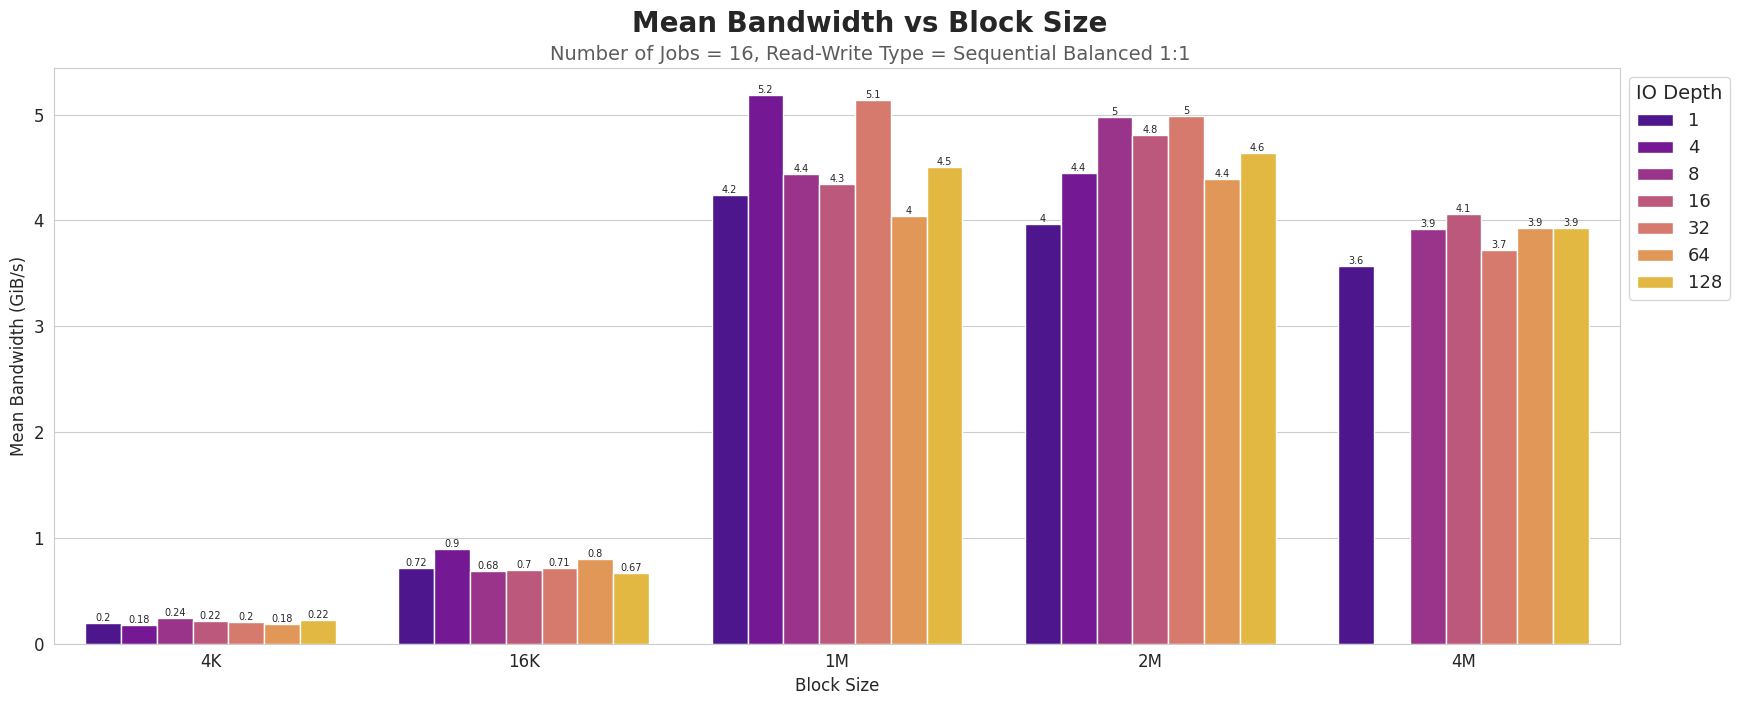

<Figure size 640x480 with 0 Axes>

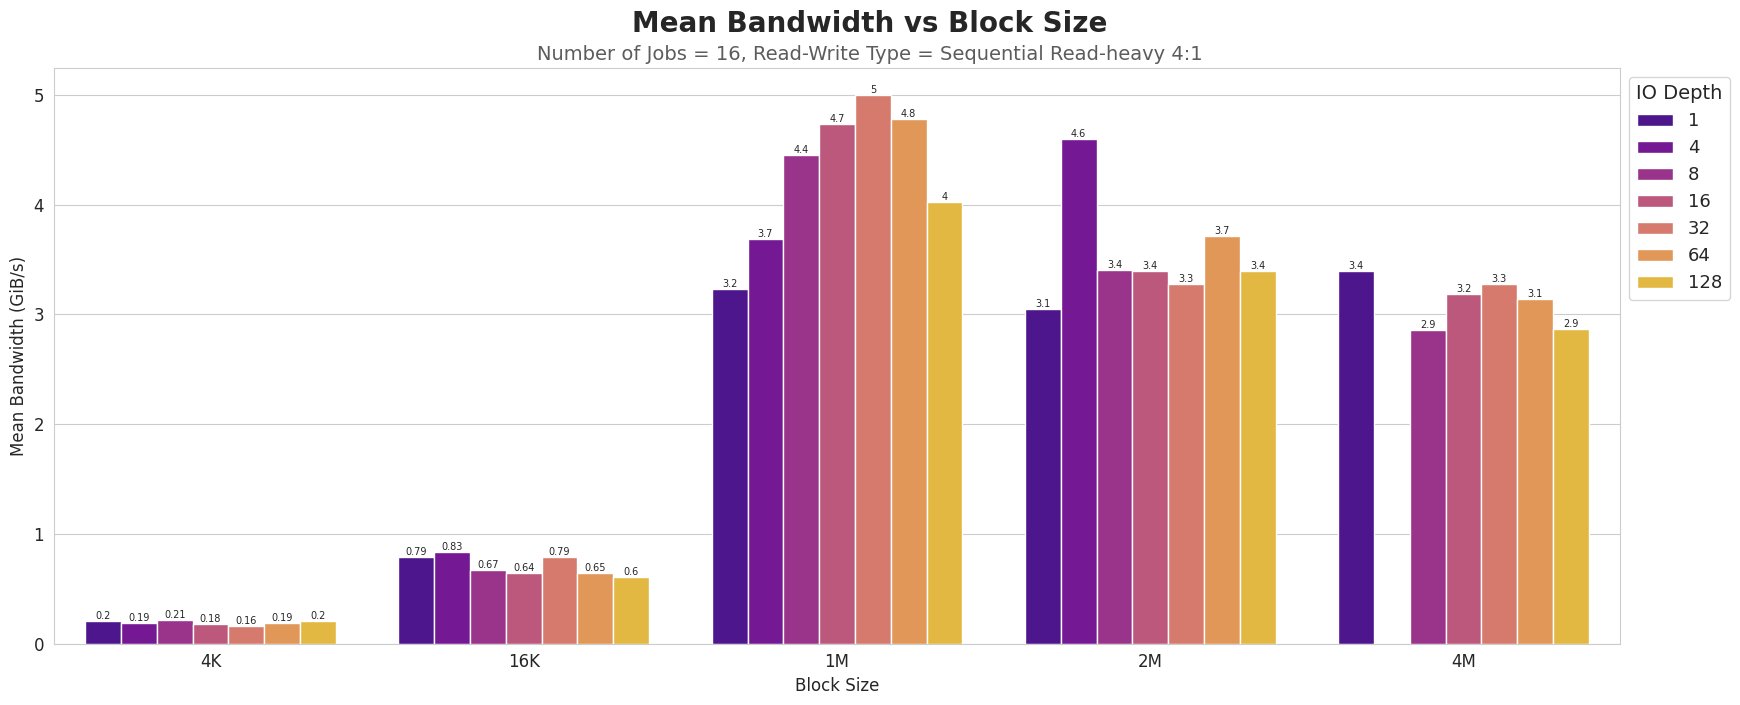

<Figure size 640x480 with 0 Axes>

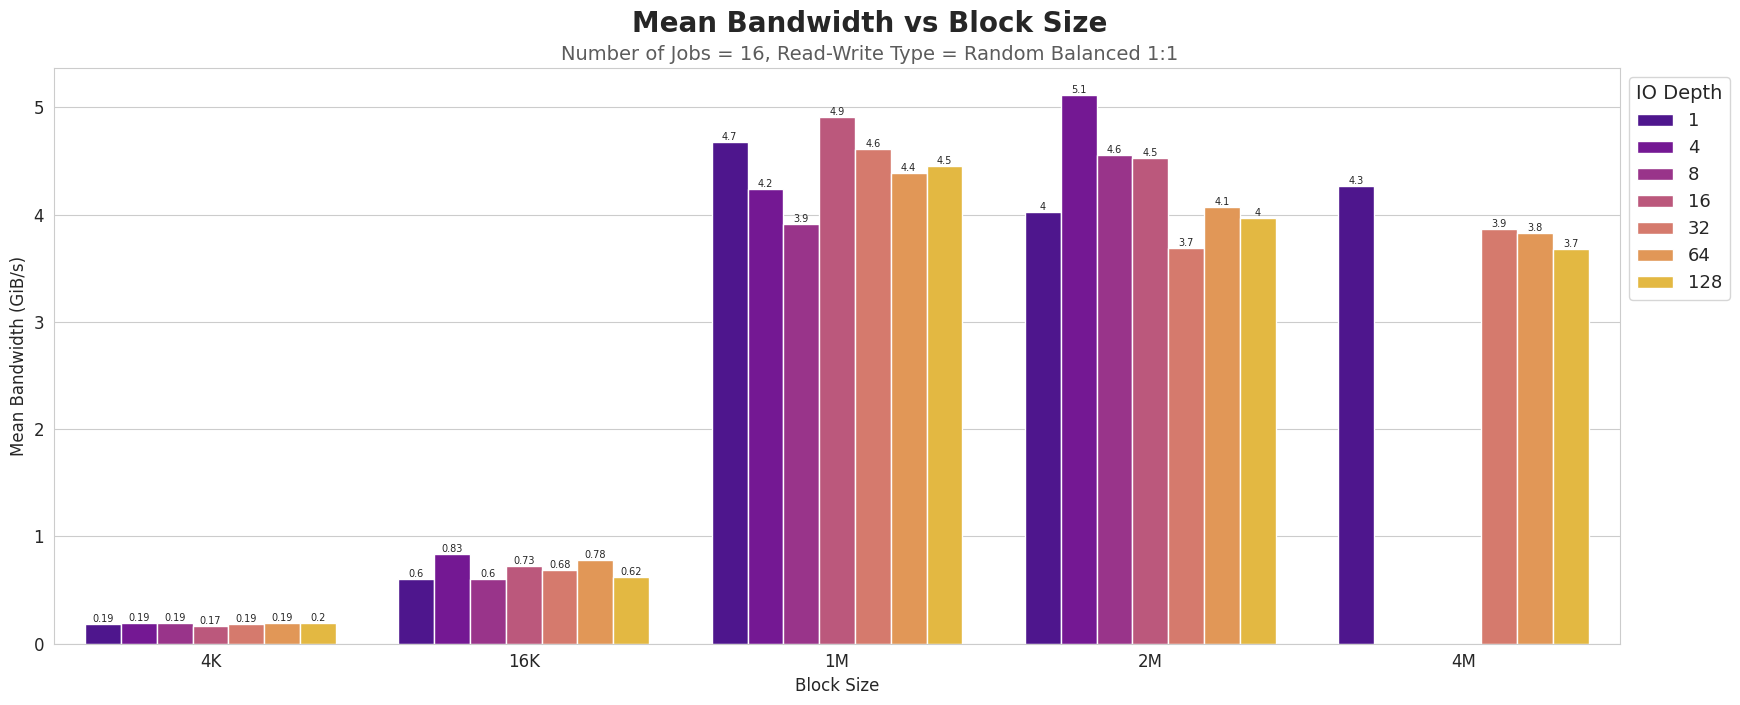

<Figure size 640x480 with 0 Axes>

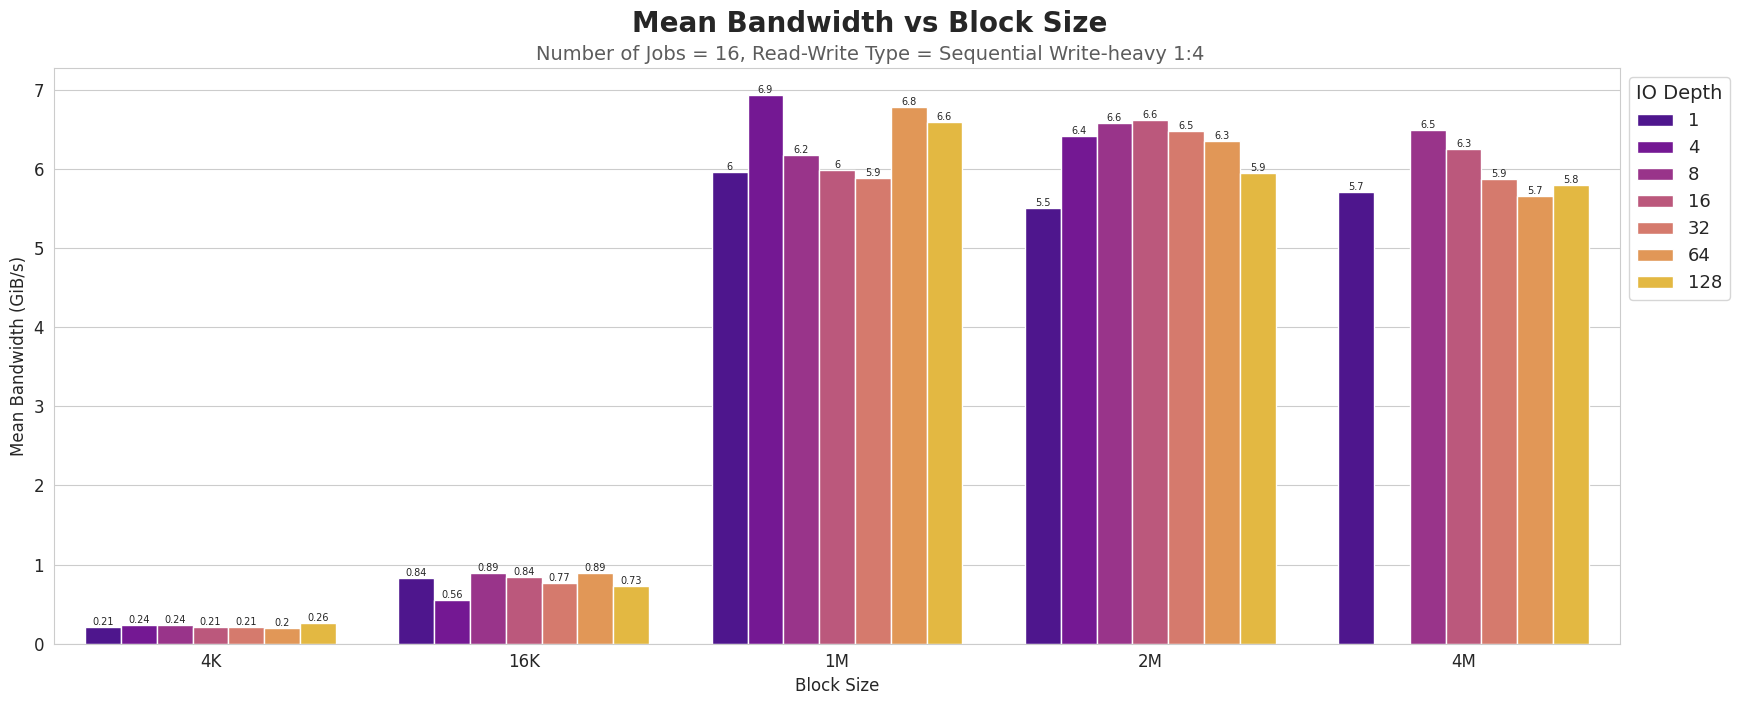

<Figure size 640x480 with 0 Axes>

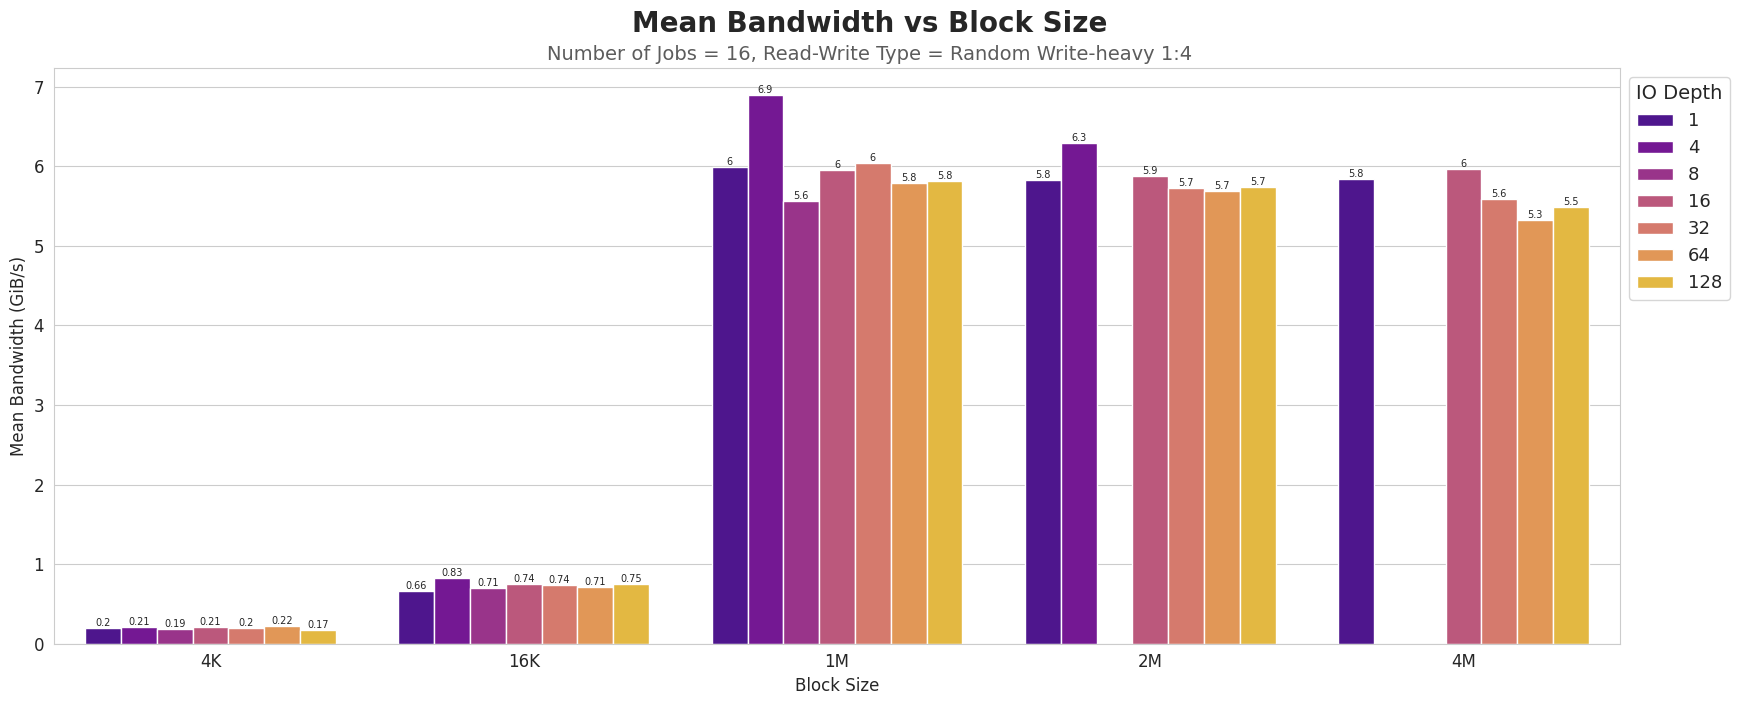

<Figure size 640x480 with 0 Axes>

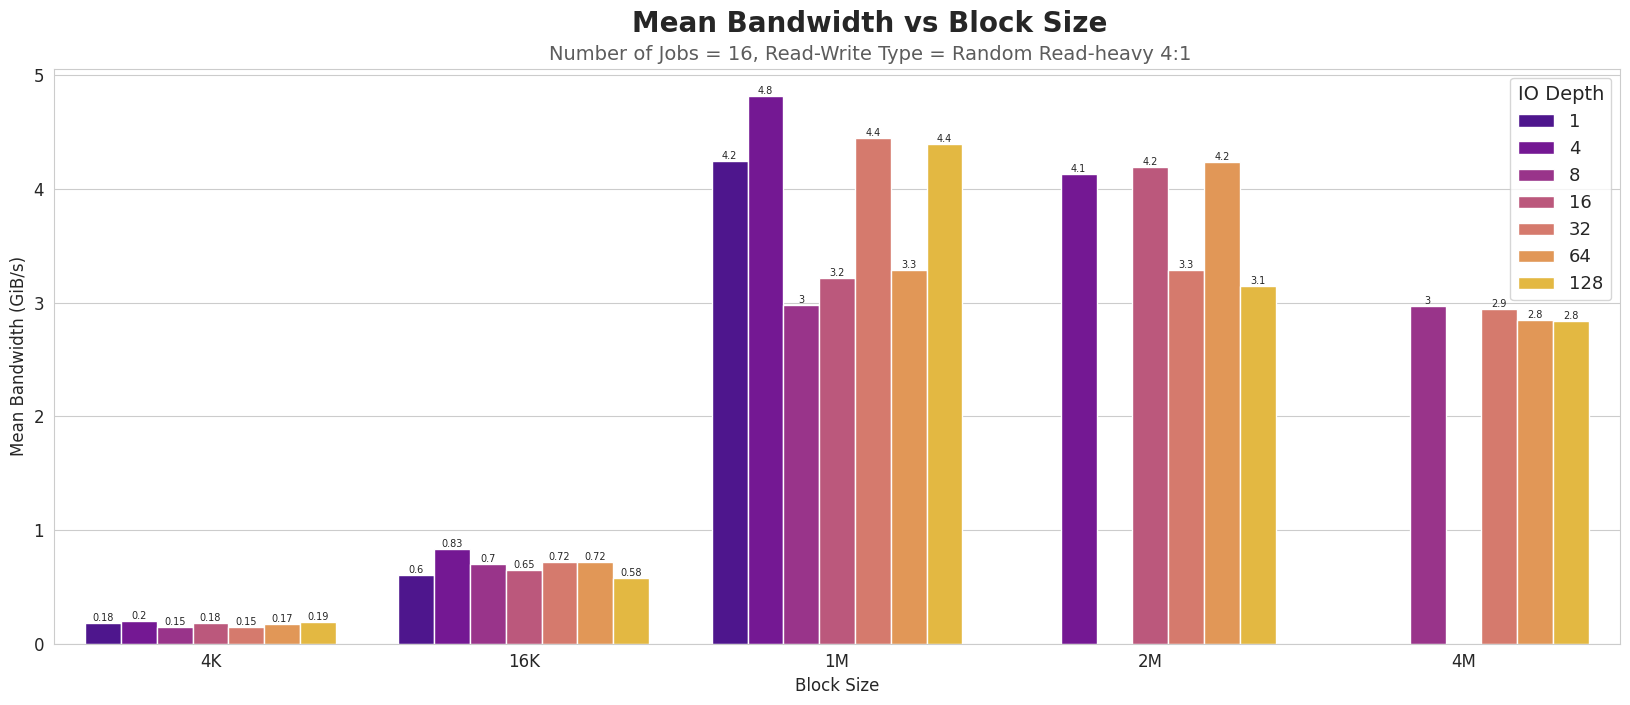

<Figure size 640x480 with 0 Axes>

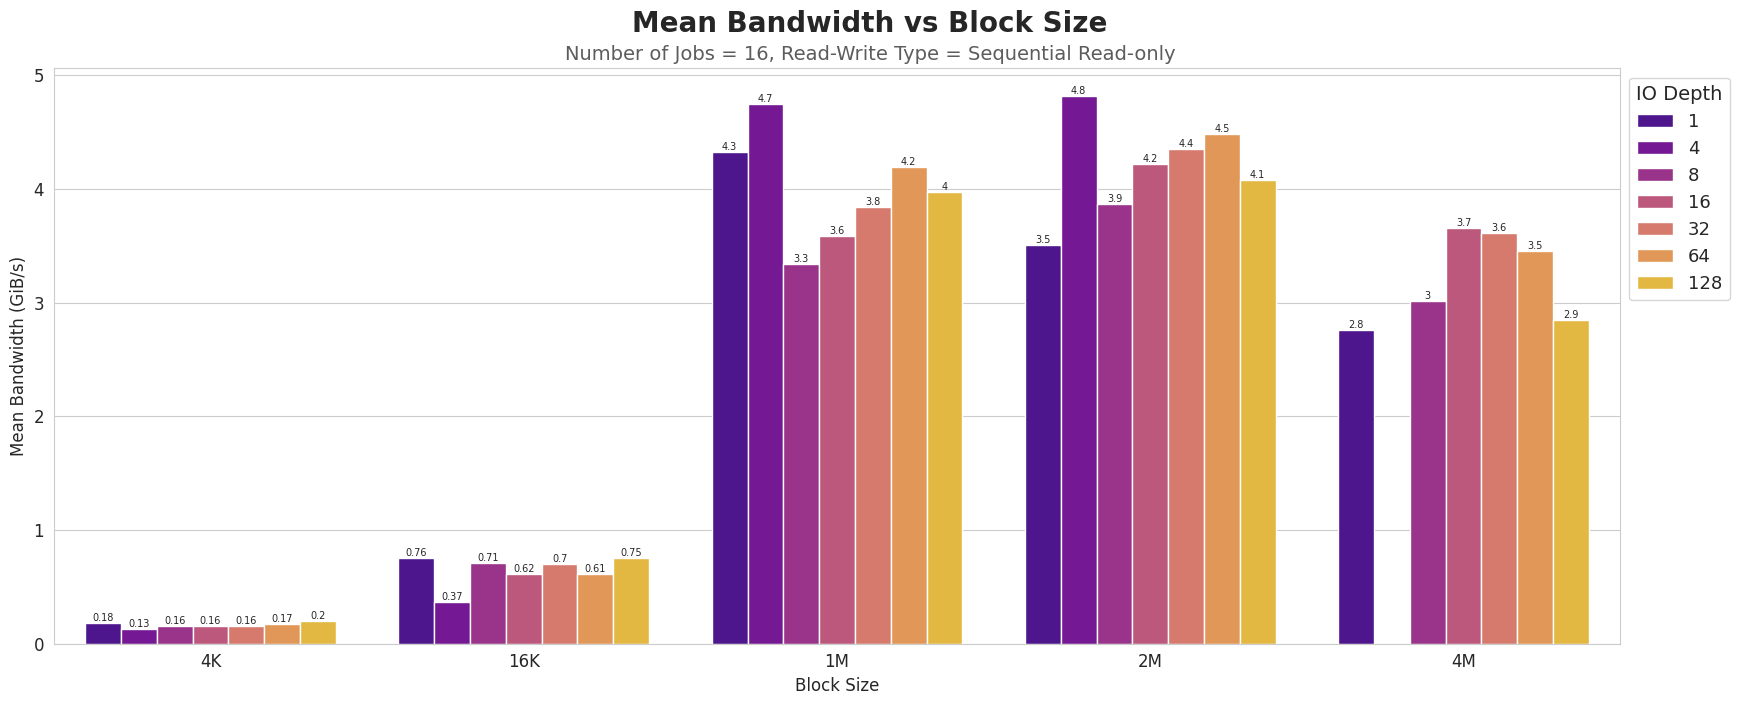

/tmp/ipykernel_79464/1195430770.py:14: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  ax = sns.barplot(


<Figure size 640x480 with 0 Axes>

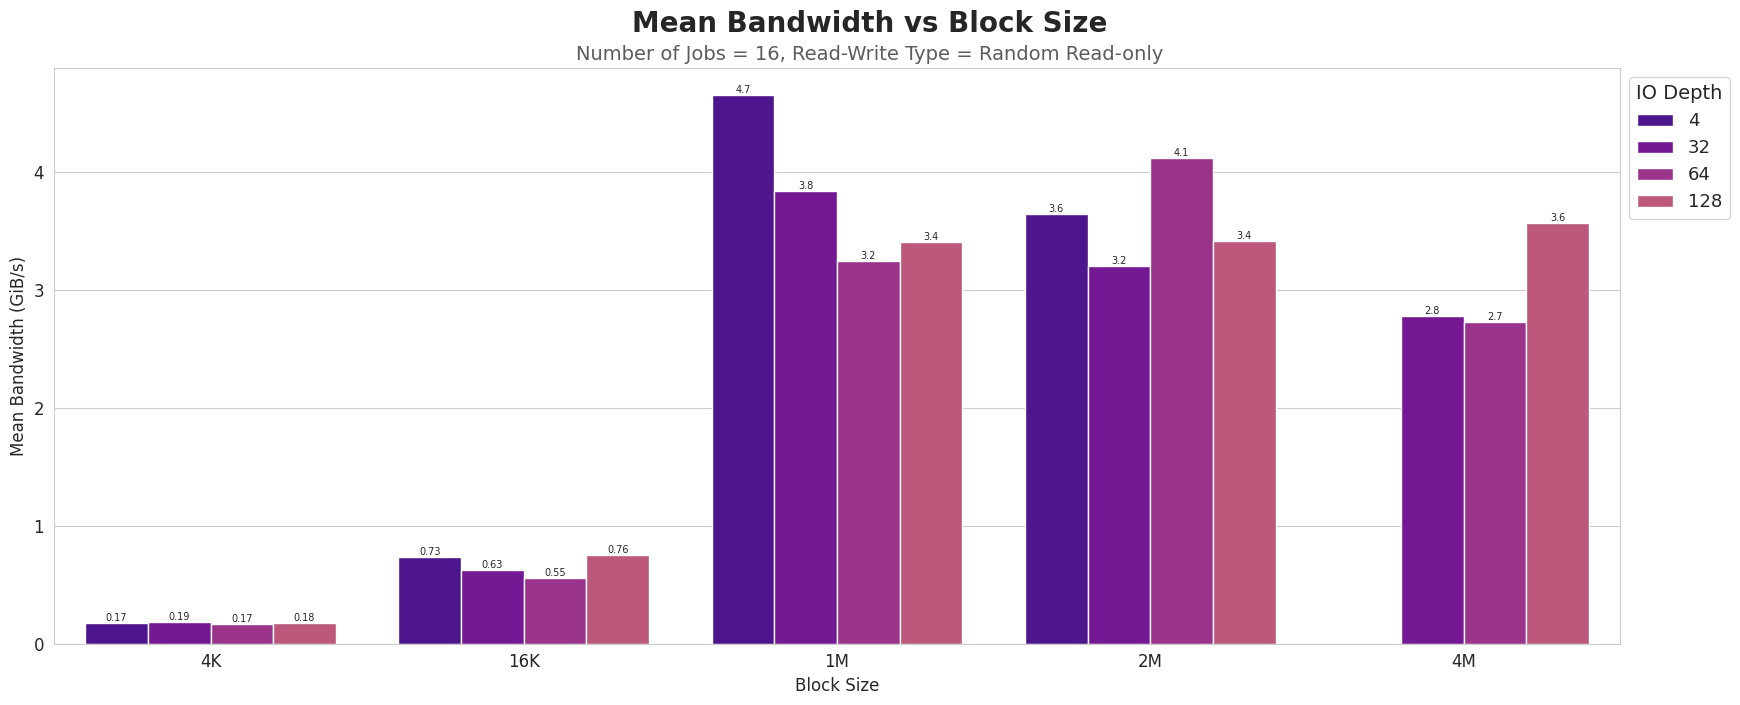

<Figure size 640x480 with 0 Axes>

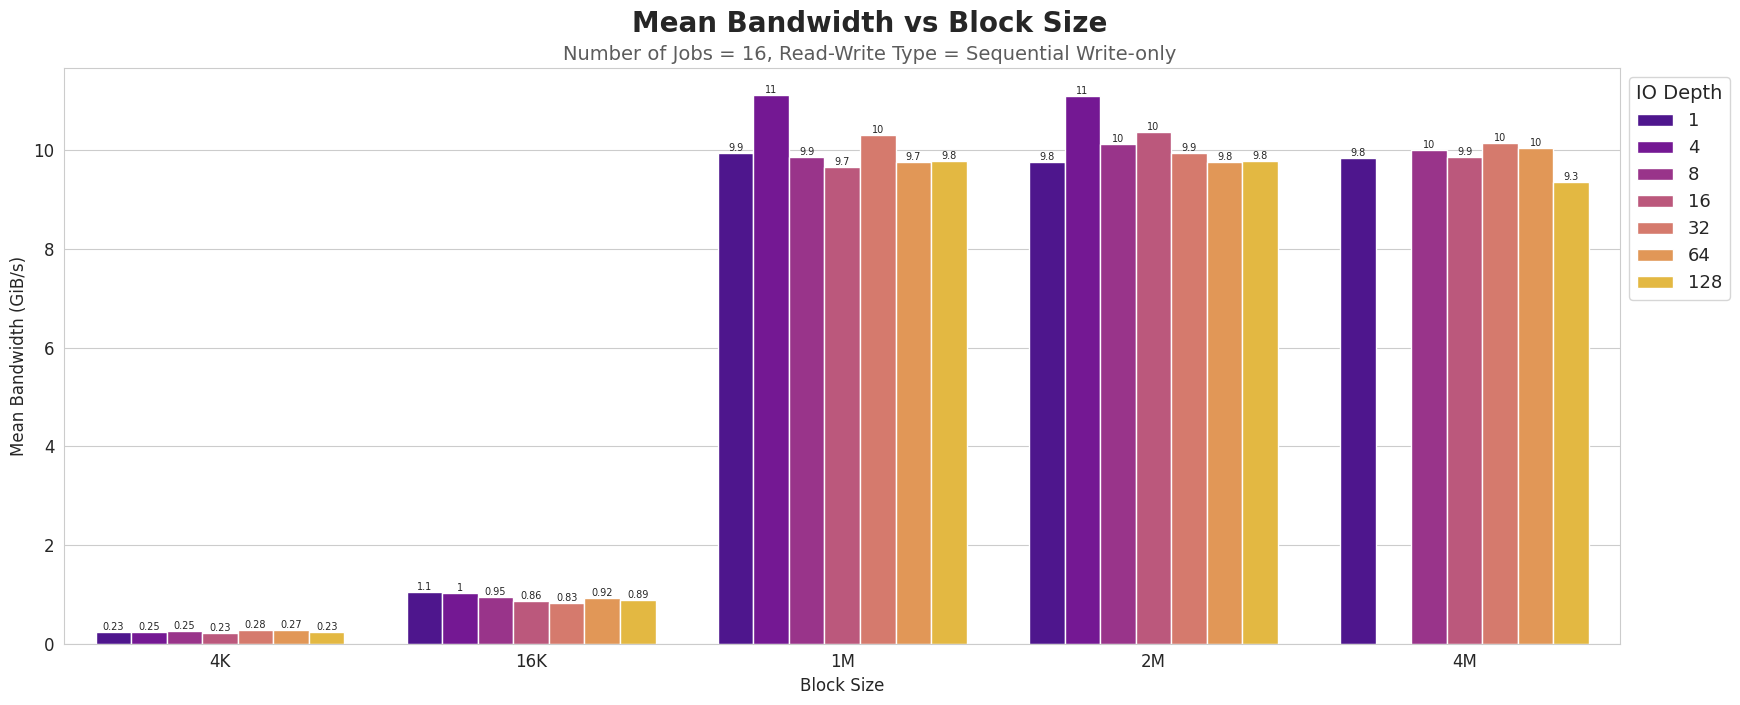

/tmp/ipykernel_79464/1195430770.py:14: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  ax = sns.barplot(


<Figure size 640x480 with 0 Axes>

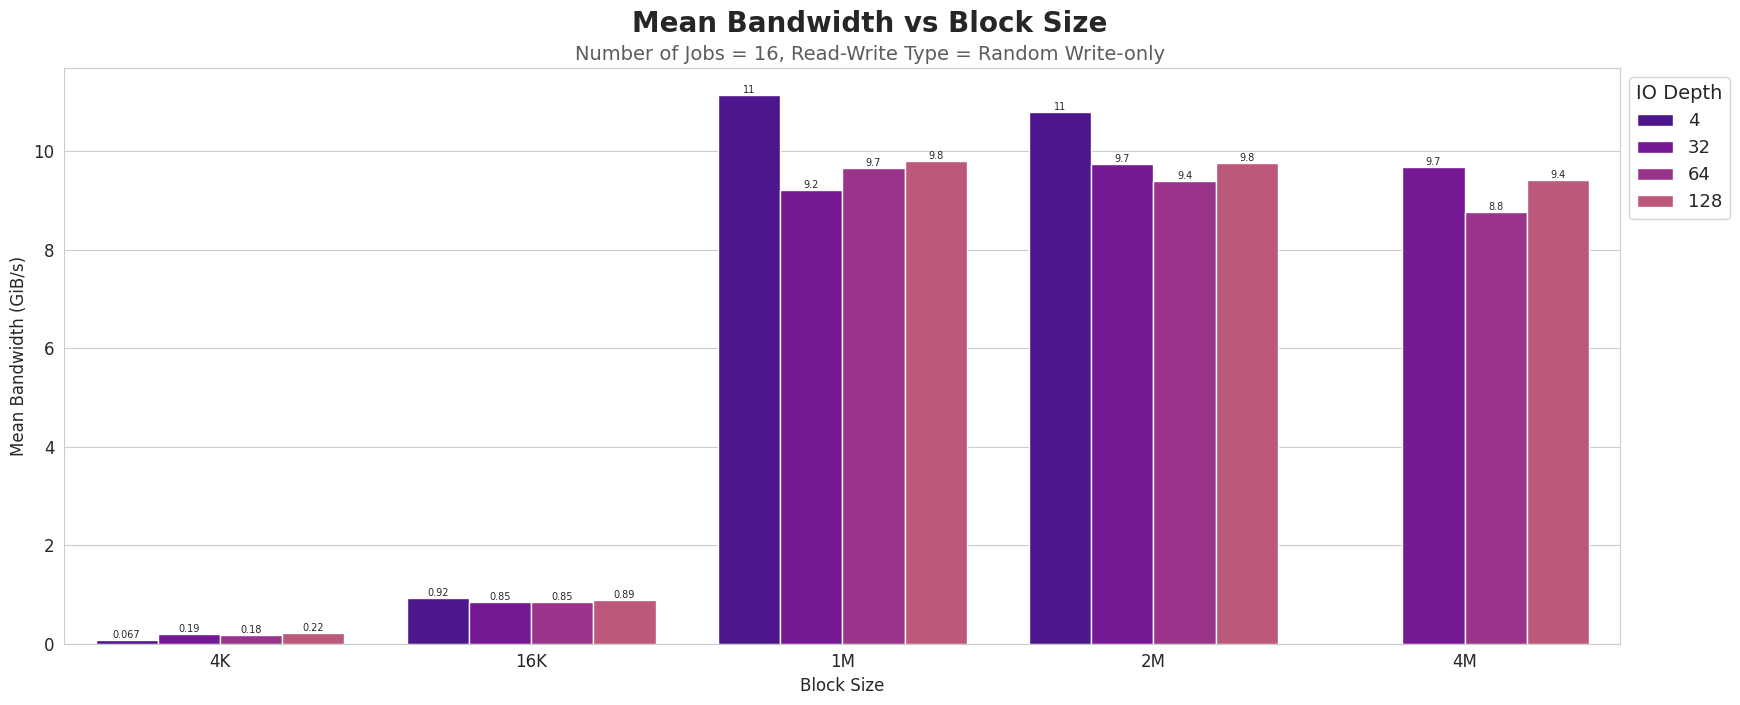

<Figure size 640x480 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

In [ ]:
# Bar graphs of bandwidth vs block size, with bars grouped by IO Depth
# One graph per numjobs / read-write type combination
palette = sns.color_palette("plasma", len(df['job options.iodepth'].unique()))

bar_width = 0.7
spacing = 0
fig_width = len(bs_order) * (5 * bar_width + spacing)

for nj in df["job options.numjobs"].unique():
    for rw_full in df["rw_full"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["rw_full"] == rw_full) ]

        fig, ax = plt.subplots(figsize=(fig_width, 7))
        ax = sns.barplot(
            data=subdf,
            x="job options.bs",
            y="bw_mean",
            hue="job options.iodepth", 
            # hue_order=hue_order,
            order=bs_order,
            palette=palette,
            errorbar=None
        )
        ax.set_xlabel("Block Size", fontsize=12)
        ax.set_ylabel("Mean Bandwidth (GiB/s)", fontsize=12)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.legend(bbox_to_anchor=(1, 1), title='IO Depth', fontsize=13, title_fontsize=14)
        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, Read-Write Type = {rw_full}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()
        for container in ax.containers:
            ax.bar_label(container, 
                            labels=[f"{v:.2g}" for v in container.datavalues], 
                            fontsize=7)
        if (nj==DISPLAY_NJ):
            # plt.savefig((png_dir + f"/fio_bw_vs_bs/fio_bw_vs_bs_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
            plt.show()
        plt.clf()

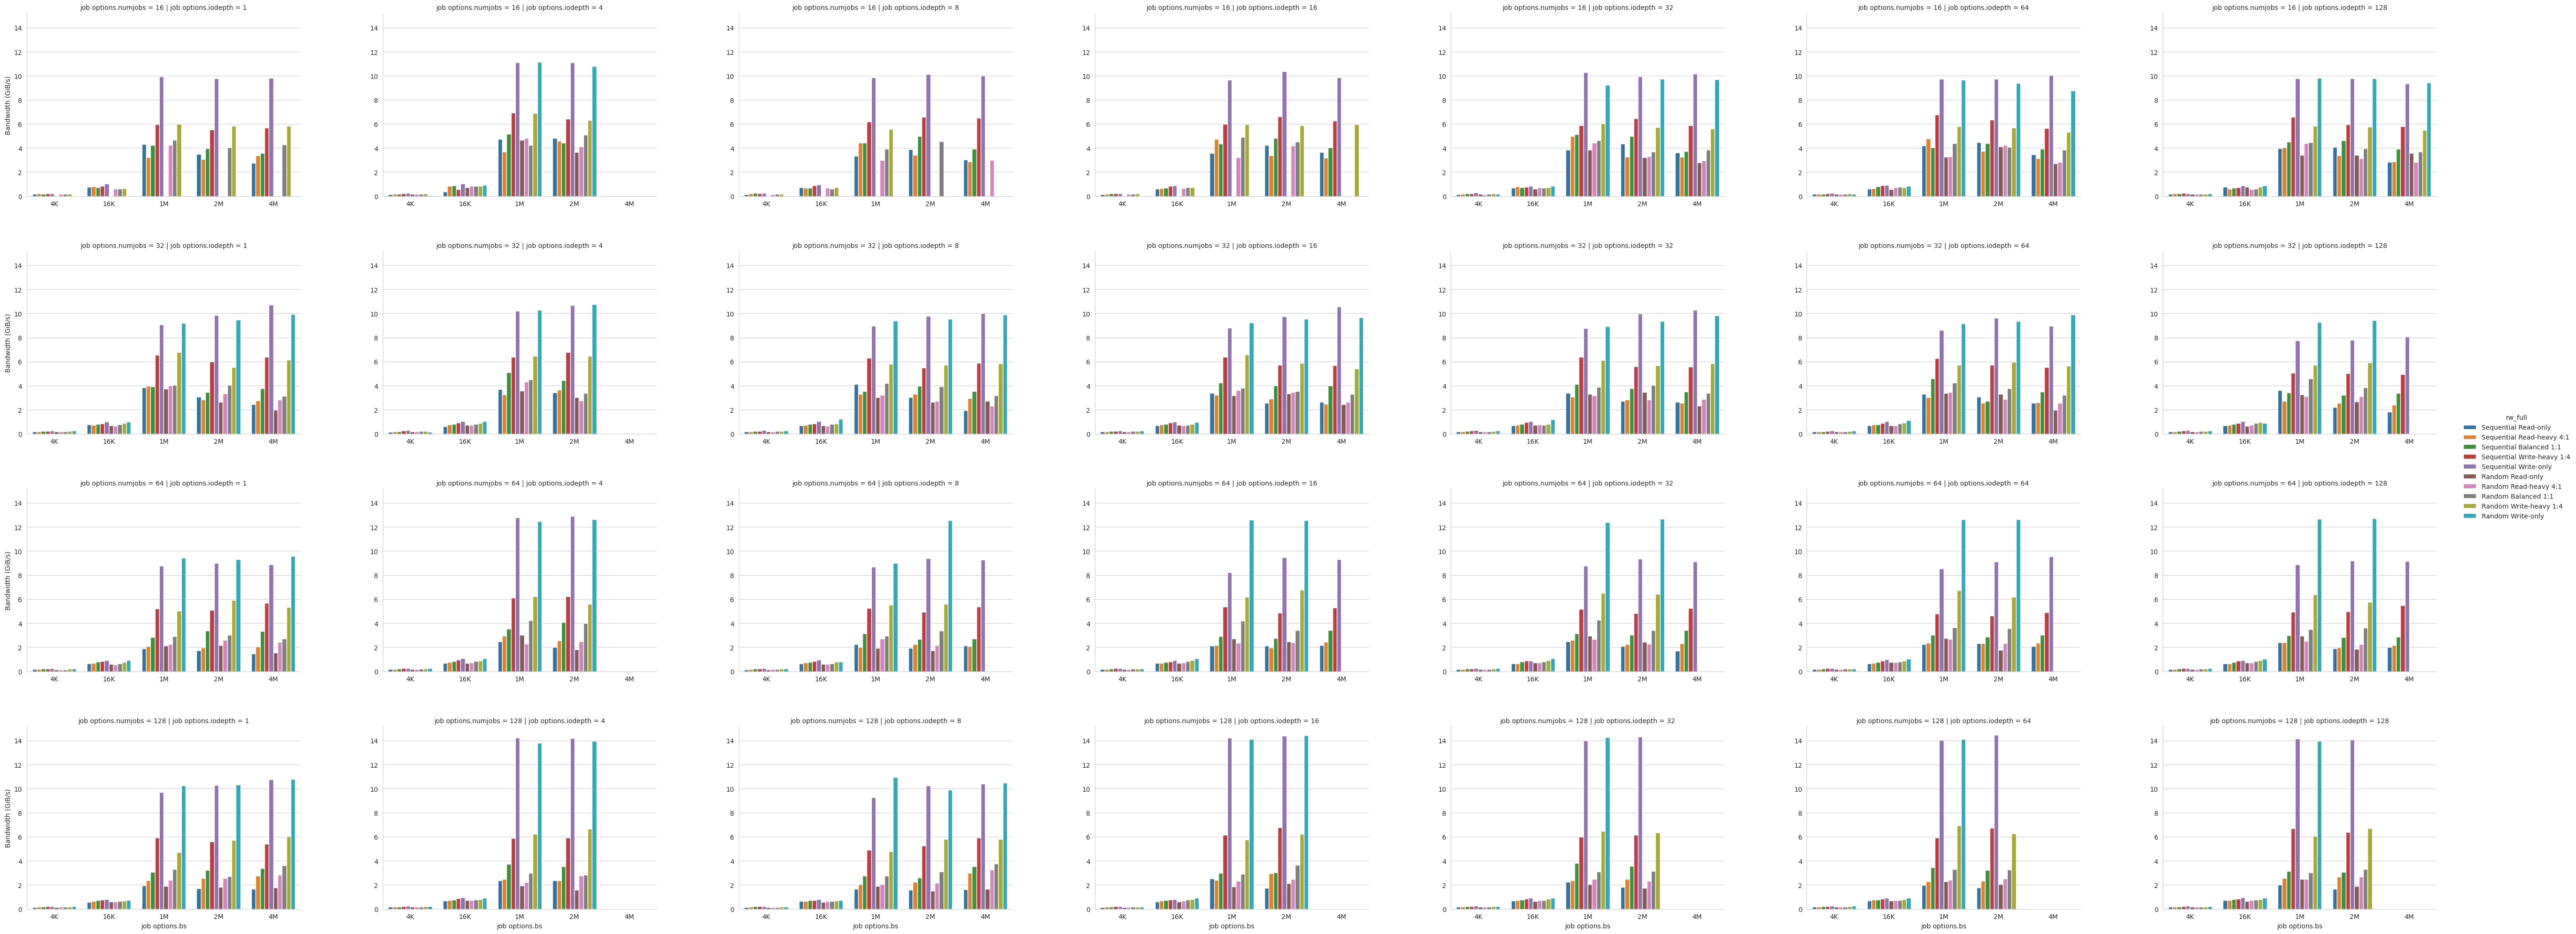

<Figure size 640x480 with 0 Axes>

In [ ]:
# Bandwidth vs Block Size, in a grid of num jobs vs iodepth
palette = sns.color_palette("plasma", 5) + sns.color_palette("mako", 5)
g = sns.catplot(data=df,
                kind="bar",
                x="job options.bs",
                hue="rw_full", 
                y="bw_mean",
                row="job options.numjobs",
                col="job options.iodepth",
                # palette=palette,
                # width=5,
                hue_order=hue_order,
                order=bs_order,
                errorbar=None,
                height=5, aspect=1.5,
                sharex=True, sharey=True
                )
# g.set_xticklabels(["4k", "16k", "1M", "2M", "4M"]) 
g.set_ylabels("Bandwidth (GiB/s)")
g.figure.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(g.axes.flat):
    ax.tick_params(
        labelbottom=True,  # show x labels
        labelleft=True     # show y labels
    )


plt.savefig((png_dir + "/fio_bandwidth/fio_bw_vs_bs_allD.svg"), bbox_inches="tight")
plt.show()
plt.clf()

/tmp/ipykernel_79464/875171183.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(fig_width, 7))


<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

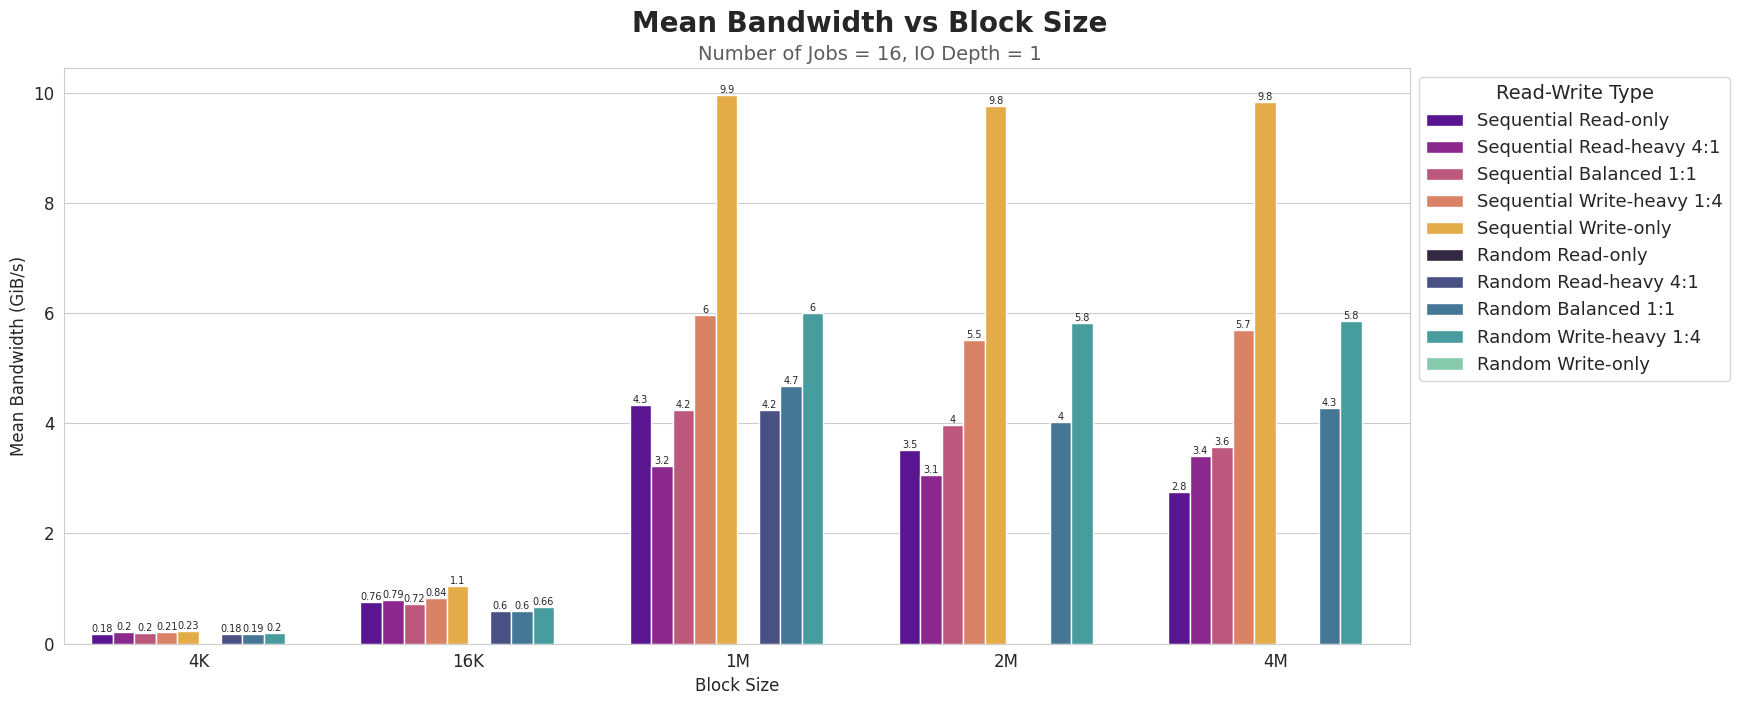

<Figure size 640x480 with 0 Axes>

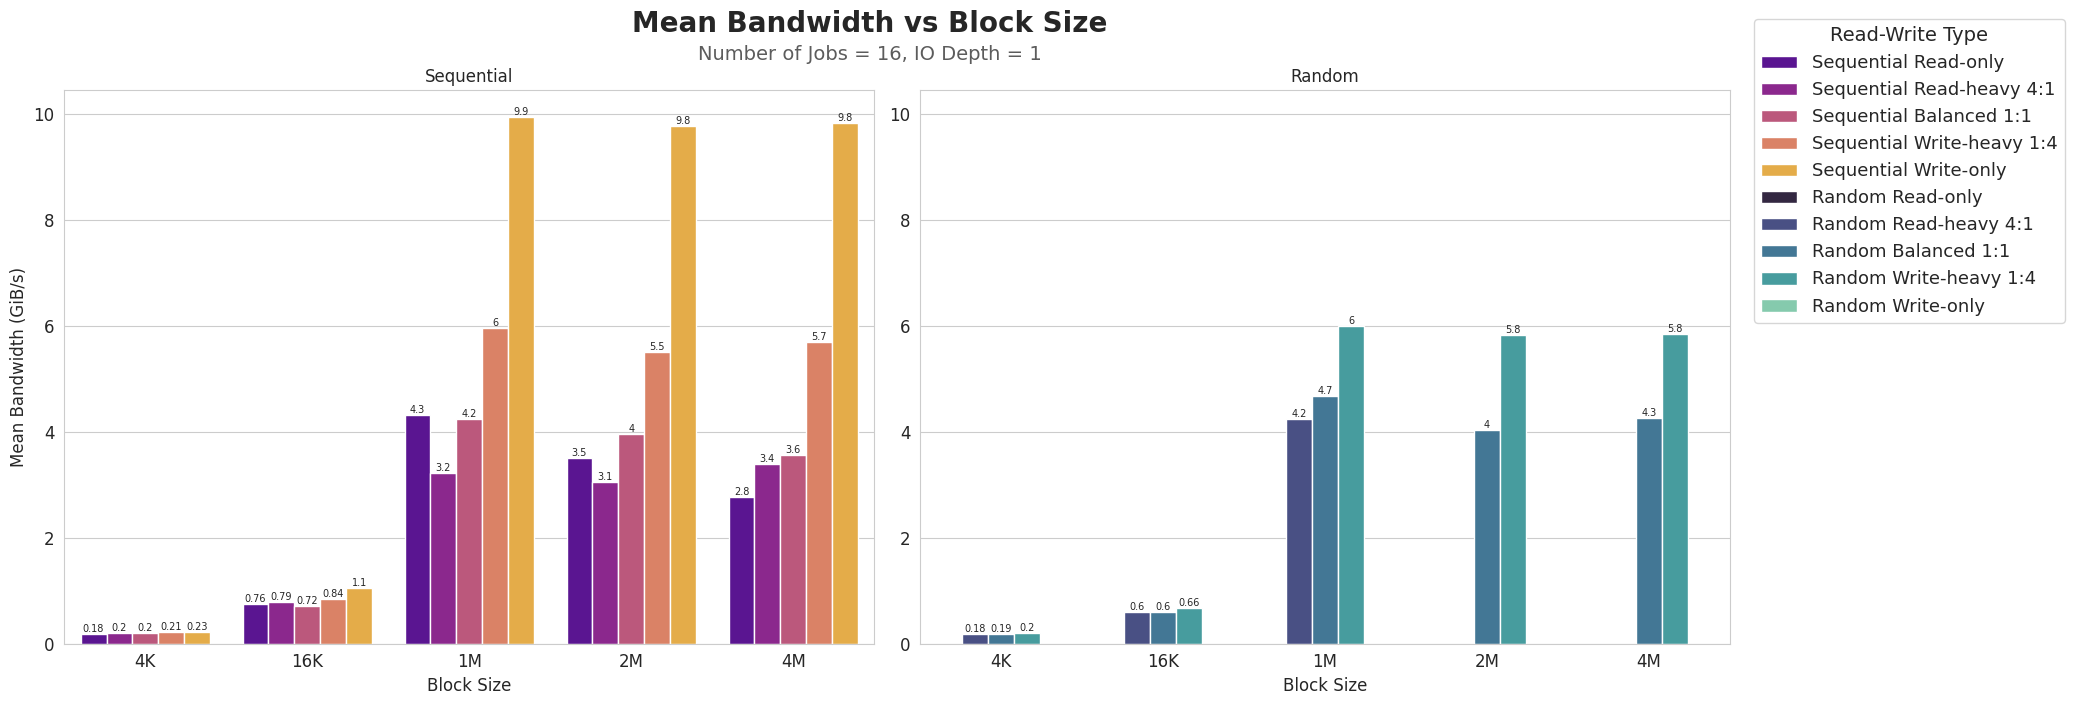

/tmp/ipykernel_79464/875171183.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,2, sharey=True, figsize=(fig_width,7))


<Figure size 640x480 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

In [ ]:
# Bandwidth vs Block Size, Each numjob/iodepth combination graphed individually

palette = sns.color_palette("plasma", 5) + sns.color_palette("mako", 5)

bar_width = 0.7
spacing = 0
fig_width = len(bs_order) * (5 * bar_width + spacing)


for nj in df["job options.numjobs"].unique():
    for iod in df["job options.iodepth"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["job options.iodepth"] == iod) ]

        # nj = subdf['job options.numjobs'].iloc[0]
        # iod = subdf['job options.iodepth'].iloc[0]

        # FULL
        fig, ax = plt.subplots(figsize=(fig_width, 7))
        ax = sns.barplot(
            data=subdf,
            x="job options.bs",
            y="bw_mean",
            hue="rw_full", 
            hue_order=hue_order,
            order=bs_order,
            palette=palette,
            errorbar=None
        )
        ax.set_xlabel("Block Size", fontsize=12)
        ax.set_ylabel("Mean Bandwidth (GiB/s)", fontsize=12)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', fontsize=13, title_fontsize=14)
        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()
        for container in ax.containers:
            ax.bar_label(container, 
                            labels=[f"{v:.2g}" for v in container.datavalues], 
                            fontsize=7)
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            plt.savefig((png_dir + f"/fio_bandwidth/fio_bw_vs_bs_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
            plt.show()
        plt.clf()

        

        # SEQUENTIAL and RANDOM side by side
        fig, axes = plt.subplots(1,2, sharey=True, figsize=(fig_width,7))
        subdf_s = subdf[subdf['rw_full'].isin(sequential_full)]
        sns.barplot(
            data=subdf_s,
            x="job options.bs",
            y="bw_mean",
            hue="rw_full", 
            hue_order=sequential_full,
            order=bs_order,
            palette=palette[:5],
            errorbar=None, 
            dodge=True,
            ax=axes[0]
        )
        axes[0].set_xlabel("Block Size", fontsize=12)
        axes[0].set_ylabel("Mean Bandwidth (GiB/s)", fontsize=12)
        axes[0].set_title("Sequential")
        # RANDOM
        subdf_r = subdf[subdf['rw_full'].isin(random_full)]
        sns.barplot(
            data=subdf_r,
            x="job options.bs",
            y="bw_mean",
            hue="rw_full", 
            hue_order=random_full,
            order=bs_order,
            palette=palette[5:],
            errorbar=None,
            dodge=True,
            ax=axes[1]
        )
        axes[1].set_xlabel("Block Size", fontsize=12)
        axes[1].set_ylabel("Mean Bandwidth (GiB/s)", fontsize=12)
        axes[1].set_title("Random")

        for ax in axes:
            ax.tick_params(labelbottom=True, labelleft=True)
            ax.tick_params(axis="x", labelsize=12)
            ax.tick_params(axis="y", labelsize=12)
            for container in ax.containers:
                ax.bar_label(container, 
                            labels=[f"{v:.2g}" for v in container.datavalues], 
                            fontsize=7)

        handles_labels = [ax.get_legend_handles_labels() for ax in axes]
        handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
        fig.legend(handles, labels, bbox_to_anchor=(1, 1), title='Read-Write Type', loc="upper left",fontsize=13, title_fontsize=14)
        if (axes[0].legend_ is not None):
            axes[0].legend_.remove()
        if(axes[1].legend_ is not None):
            axes[1].legend_.remove()

        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            plt.savefig((png_dir + f"/fio_bandwidth/fio_bw_vs_bs_SR_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
            plt.show()
        plt.clf()

/tmp/ipykernel_79464/1664447897.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_79464/1664447897.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_79464/1664447897.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_79464/1664447897.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_79464/1664447897.

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

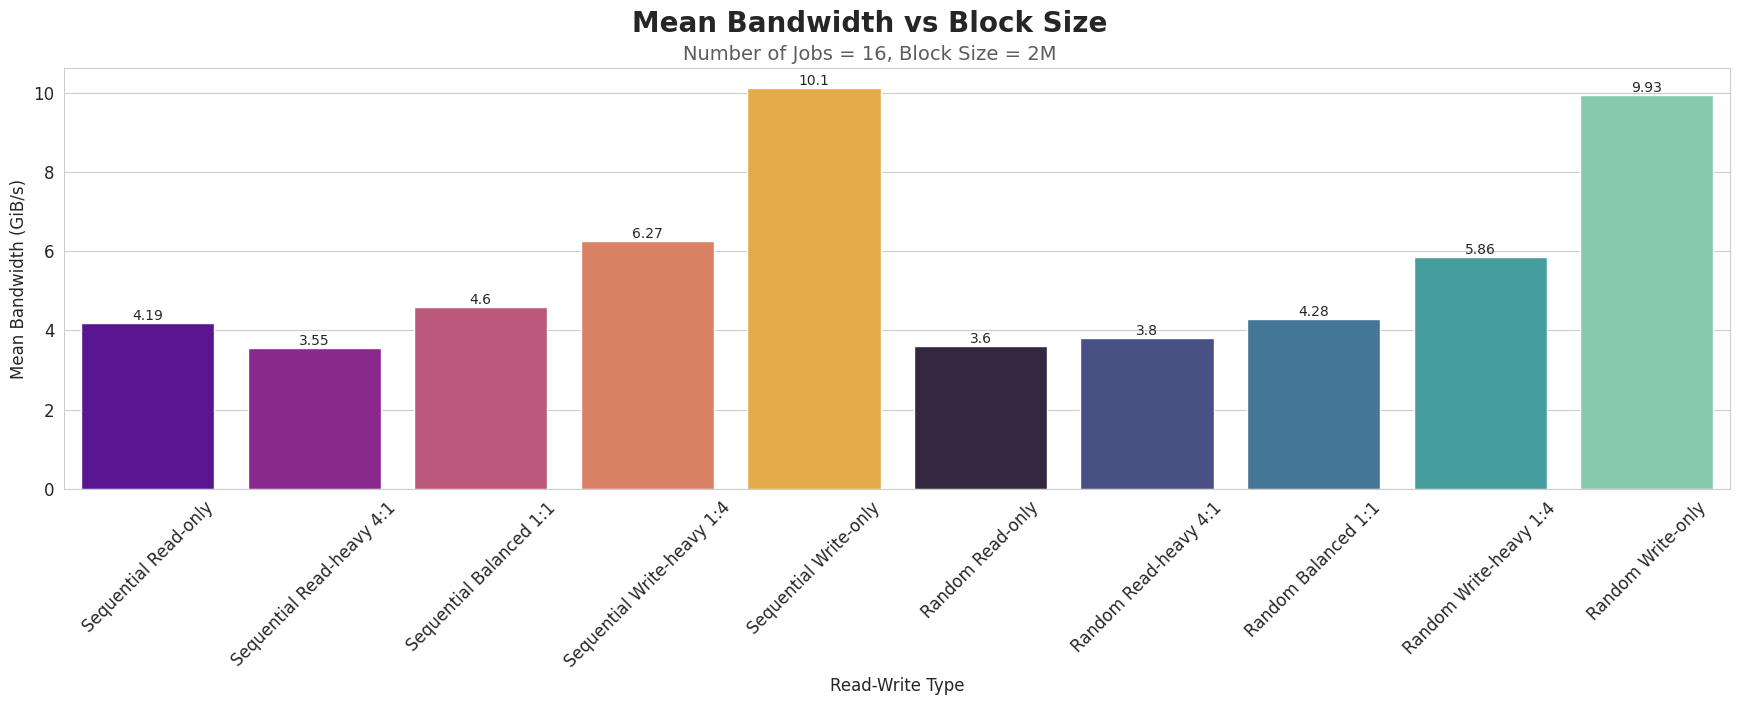

/tmp/ipykernel_79464/1664447897.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


<Figure size 640x480 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

In [ ]:
palette = sns.color_palette("plasma", 5) + sns.color_palette("mako", 5)

bar_width = 0.7
spacing = 0
fig_width = len(bs_order) * (5 * bar_width + spacing)

for bs in df["job options.bs"].unique():
    for nj in df["job options.numjobs"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["job options.bs"] == bs) ]

        fig, ax = plt.subplots(figsize=(fig_width, 7))
        ax = sns.barplot(
            data=subdf,
            x="rw_full",
            y="bw_mean",
            # hue="rw_full", 
            # hue_order=hue_order,
            order=hue_order,
            palette=palette,
            errorbar=None,
            legend=False
        )
        ax.set_xlabel("Read-Write Type", fontsize=12)
        ax.set_ylabel("Mean Bandwidth (GiB/s)", fontsize=12)
        ax.tick_params(axis="x", labelrotation=45, labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        # ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', fontsize=13, title_fontsize=14)
        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, Block Size = {bs}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()
        for container in ax.containers:
            ax.bar_label(container, 
                            labels=[f"{v:.3g}" for v in container.datavalues], 
                            fontsize=10)
        if (nj==DISPLAY_NJ and bs==DISPLAY_BS):
            # plt.savefig((png_dir + f"/fio_bw_vs_bs/fio_bw_vs_bs_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
            plt.show()
        plt.clf()

# IOPS Plots

/tmp/ipykernel_79464/535060129.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(fig_width, 7))


<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

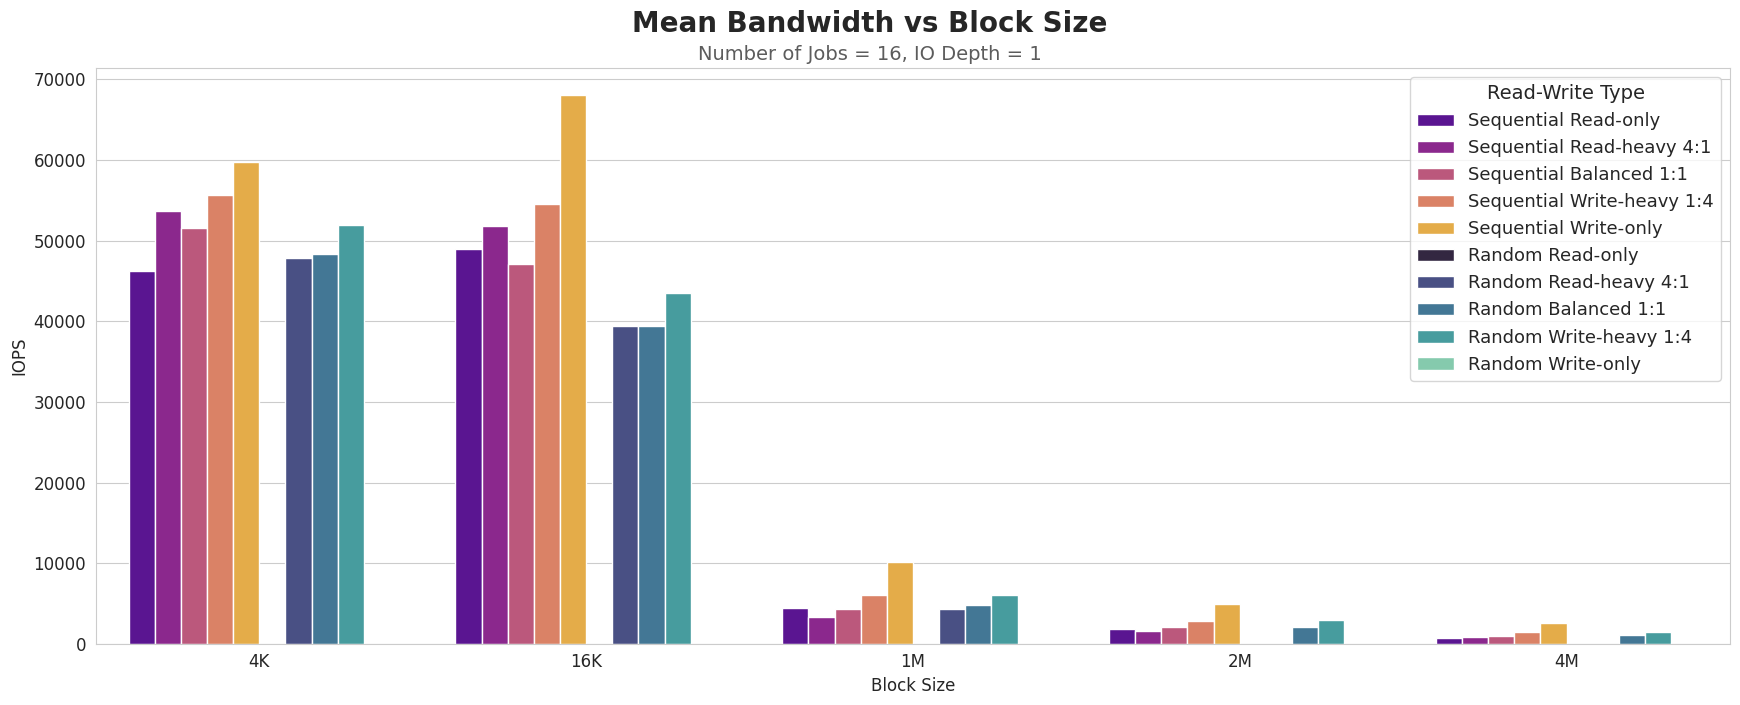

<Figure size 640x480 with 0 Axes>

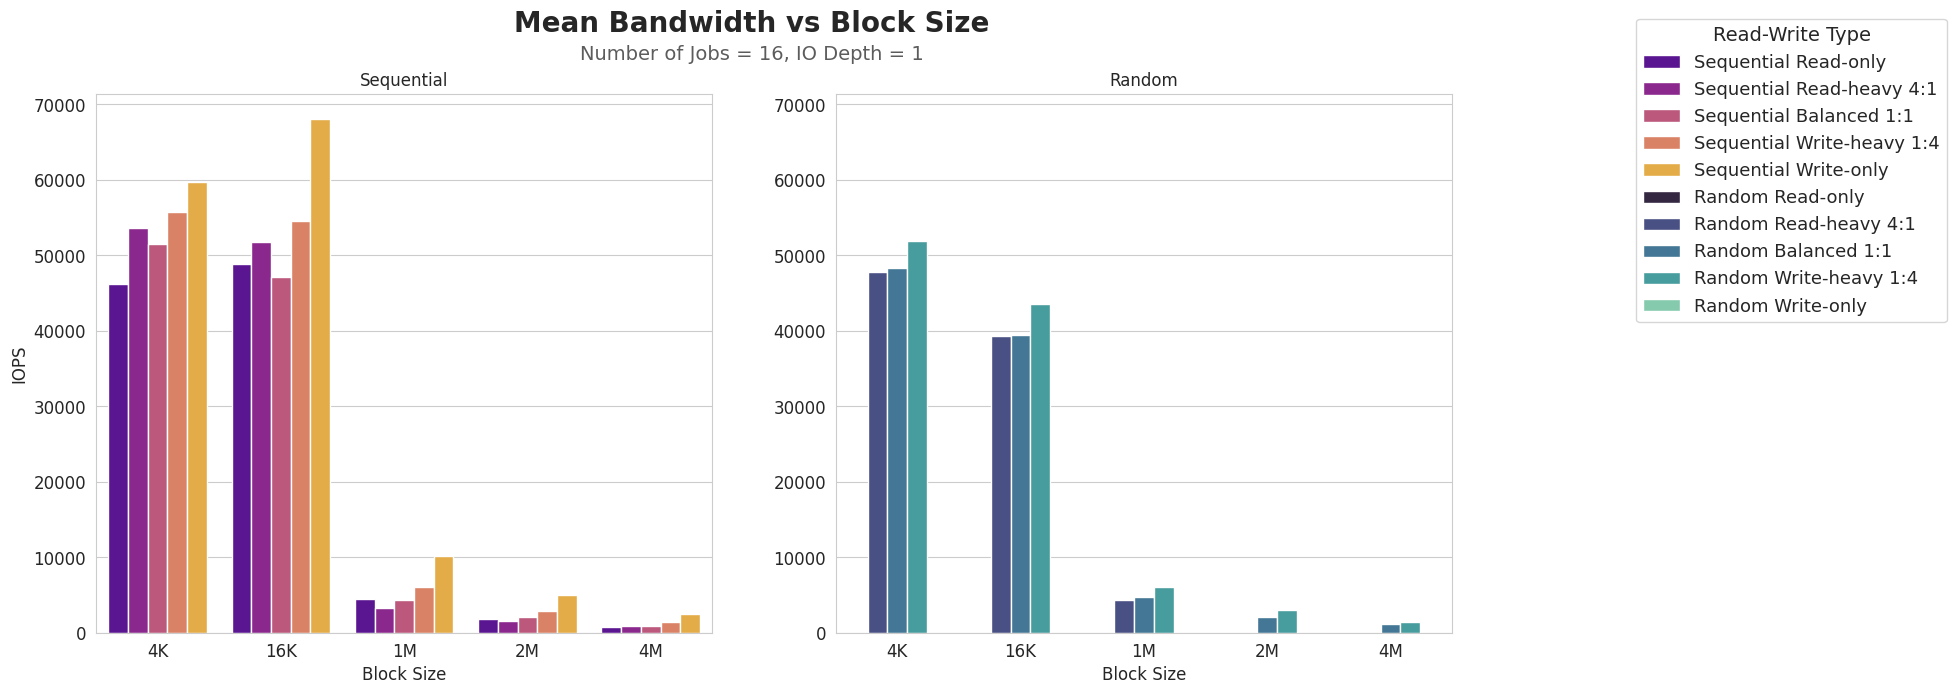

/tmp/ipykernel_79464/535060129.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,2, sharey=True, figsize=(fig_width,7))


<Figure size 640x480 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

In [ ]:
palette = sns.color_palette("plasma", 5) + sns.color_palette("mako", 5)

bar_width = 0.7
spacing = 0
fig_width = len(bs_order) * (5 * bar_width + spacing)


for nj in df["job options.numjobs"].unique():
    for iod in df["job options.iodepth"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["job options.iodepth"] == iod) ]

        # FULL
        fig, ax = plt.subplots(figsize=(fig_width, 7))
        ax = sns.barplot(
            data=subdf,
            x="job options.bs",
            y="iops",
            hue="rw_full", 
            hue_order=hue_order,
            order=bs_order,
            palette=palette,
            errorbar=None
        )
        ax.set_xlabel("Block Size", fontsize=12)
        ax.set_ylabel("IOPS", fontsize=12)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', fontsize=13, title_fontsize=14)
        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()
        # for container in ax.containers:
        #     ax.bar_label(container, 
        #                     labels=[f"{v:.2g}" for v in container.datavalues], 
        #                     fontsize=7)
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            # plt.savefig((png_dir + f"/fio_iops/fio_iops_vs_bs_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
            plt.show()
        plt.clf()

        

        # SEQUENTIAL and RANDOM side by side
        fig, axes = plt.subplots(1,2, sharey=True, figsize=(fig_width,7))
        subdf_s = subdf[subdf['rw_full'].isin(sequential_full)]
        sns.barplot(
            data=subdf_s,
            x="job options.bs",
            y="iops",
            hue="rw_full", 
            hue_order=sequential_full,
            order=bs_order,
            palette=palette[:5],
            errorbar=None, 
            dodge=True,
            ax=axes[0]
        )
        axes[0].set_xlabel("Block Size", fontsize=12)
        axes[0].set_ylabel("IOPS", fontsize=12)
        axes[0].set_title("Sequential")
        # RANDOM
        subdf_r = subdf[subdf['rw_full'].isin(random_full)]
        sns.barplot(
            data=subdf_r,
            x="job options.bs",
            y="iops",
            hue="rw_full", 
            hue_order=random_full,
            order=bs_order,
            palette=palette[5:],
            errorbar=None,
            dodge=True,
            ax=axes[1]
        )
        axes[1].set_xlabel("Block Size", fontsize=12)
        axes[1].set_ylabel("IOPS", fontsize=12)
        axes[1].set_title("Random")

        for ax in axes:
            ax.tick_params(labelbottom=True, labelleft=True)
            ax.tick_params(axis="x", labelsize=12)
            ax.tick_params(axis="y", labelsize=12)
            # for container in ax.containers:
            #     ax.bar_label(container, 
            #                 labels=[f"{v:.2g}" for v in container.datavalues], 
            #                 fontsize=7)

        handles_labels = [ax.get_legend_handles_labels() for ax in axes]
        handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
        fig.legend(handles, labels, bbox_to_anchor=(1, 1), title='Read-Write Type', loc="upper left",fontsize=13, title_fontsize=14)
        if (axes[0].legend_ is not None):
            axes[0].legend_.remove()
        if(axes[1].legend_ is not None):
            axes[1].legend_.remove()

        fig.suptitle("Mean Bandwidth vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        # fig.tight_layout()
        # plt.savefig((png_dir + f"/fio_bandwidth/fio_bw_vs_bs_SR_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            plt.show()
            # plt.savefig((png_dir + f"/fio_bandwidth/fio_bw_vs_bs_SR_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
      
        plt.clf()

# Latency Plots

/tmp/ipykernel_79464/1598390920.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(fig_width, 7))


<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

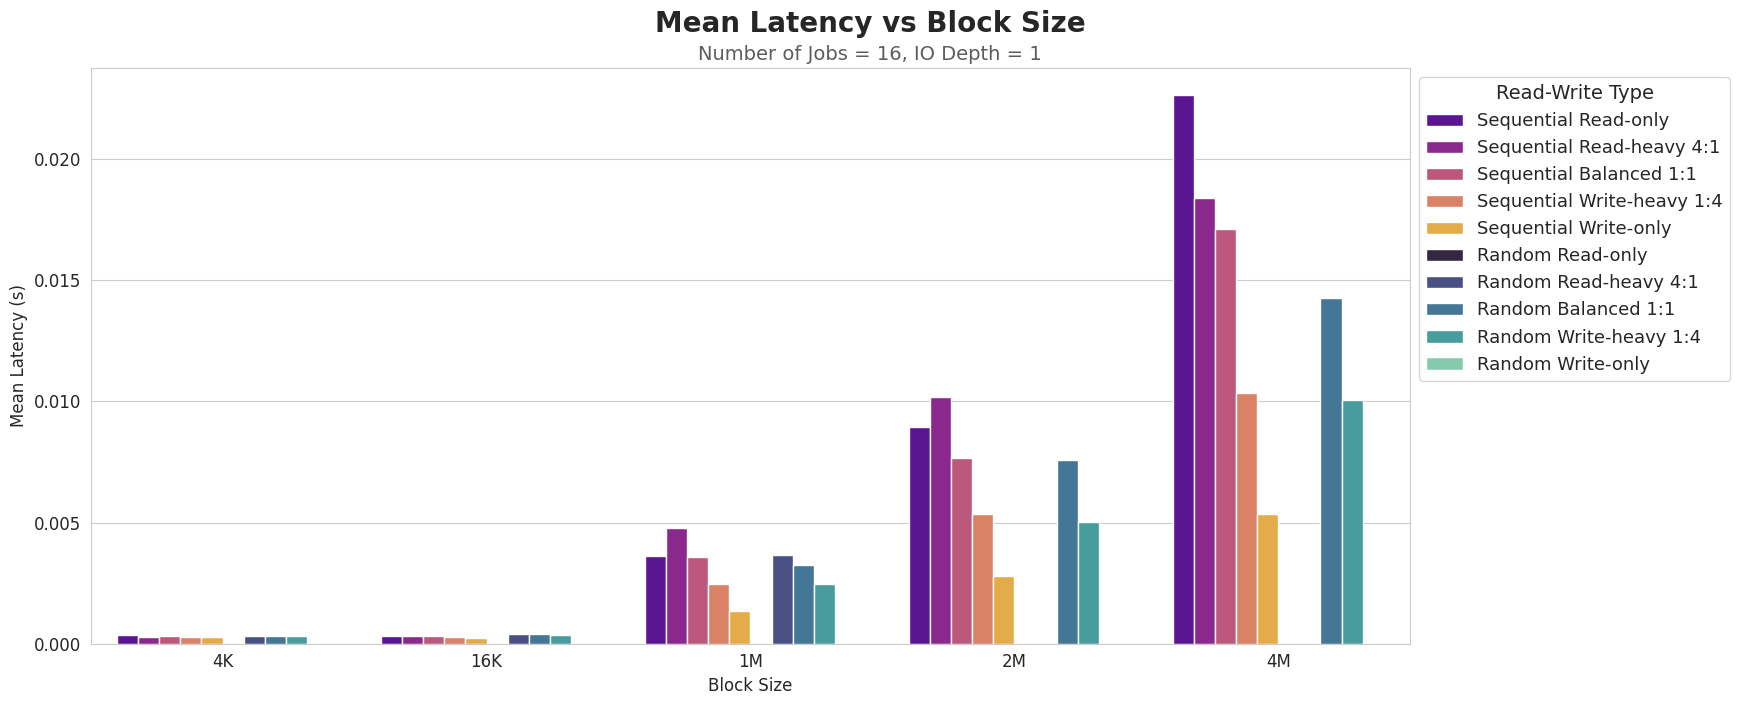

<Figure size 640x480 with 0 Axes>

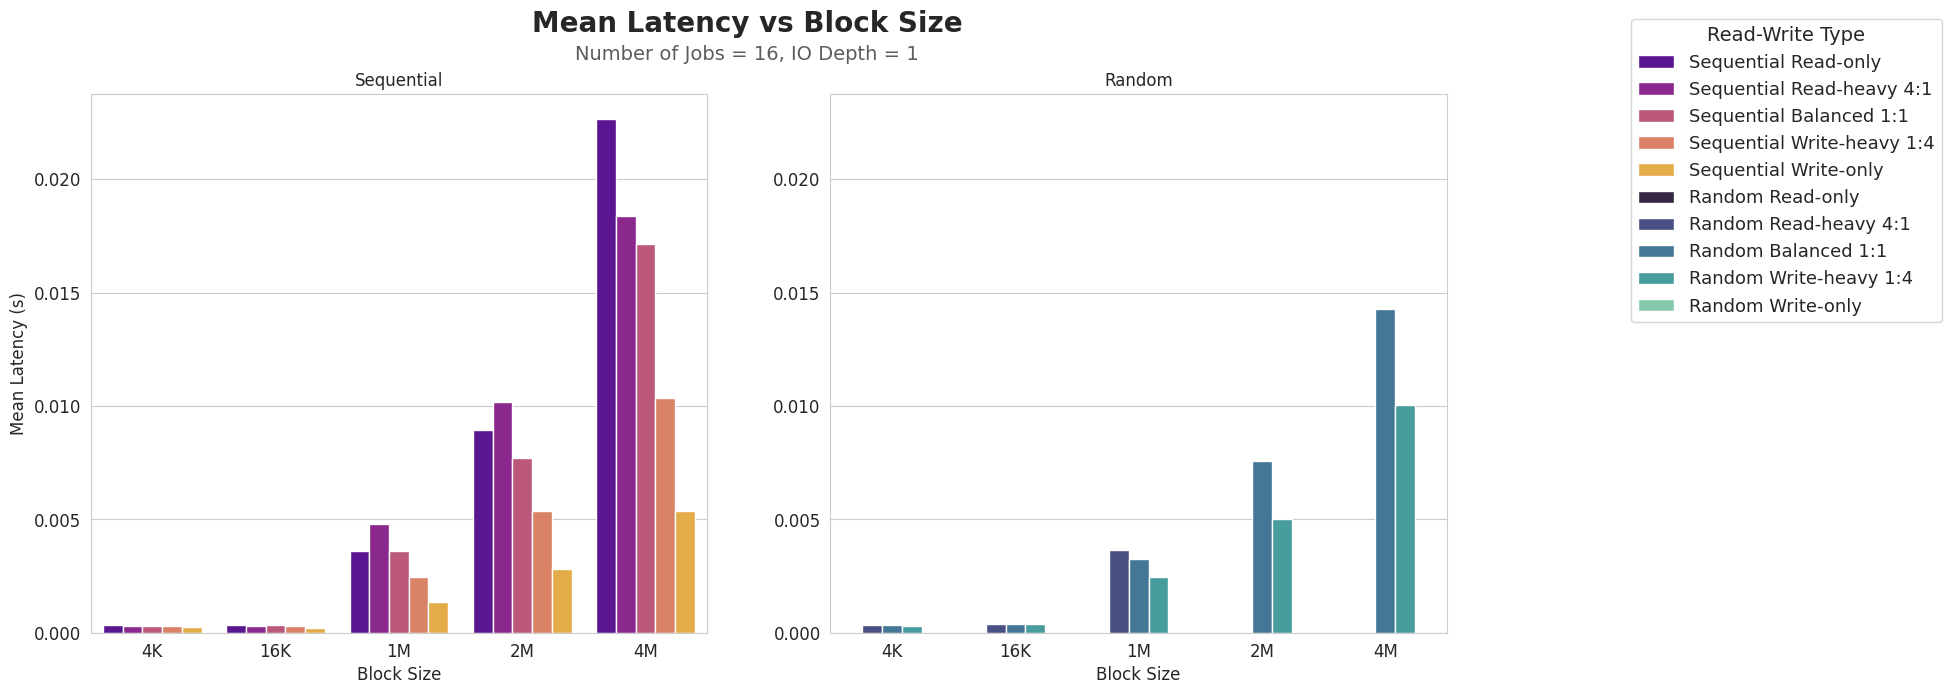

/tmp/ipykernel_79464/1598390920.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,2, sharey=True, figsize=(fig_width,7))


<Figure size 640x480 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

<Figure size 1750x700 with 0 Axes>

In [ ]:
palette = sns.color_palette("plasma", 5) + sns.color_palette("mako", 5)

bar_width = 0.7
spacing = 0
fig_width = len(bs_order) * (5 * bar_width + spacing)


for nj in df["job options.numjobs"].unique():
    for iod in df["job options.iodepth"].unique():
        subdf = df[ (df["job options.numjobs"] == nj) & (df["job options.iodepth"] == iod) ]

        # FULL
        fig, ax = plt.subplots(figsize=(fig_width, 7))
        ax = sns.barplot(
            data=subdf,
            x="job options.bs",
            y="lat_s.mean",
            hue="rw_full", 
            hue_order=hue_order,
            order=bs_order,
            palette=palette,
            errorbar=None
        )
        ax.set_xlabel("Block Size", fontsize=12)
        ax.set_ylabel("Mean Latency (s)", fontsize=12)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.legend(bbox_to_anchor=(1, 1), title='Read-Write Type', fontsize=13, title_fontsize=14)
        fig.suptitle("Mean Latency vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        fig.tight_layout()
        # for container in ax.containers:
        #     ax.bar_label(container, 
        #                     labels=[f"{v:.2g}" for v in container.datavalues], 
        #                     fontsize=7)
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            # plt.savefig((png_dir + f"/fio_iops/fio_iops_vs_bs_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
            plt.show()
        plt.clf()

        

        # SEQUENTIAL and RANDOM side by side
        fig, axes = plt.subplots(1,2, sharey=True, figsize=(fig_width,7))
        subdf_s = subdf[subdf['rw_full'].isin(sequential_full)]
        sns.barplot(
            data=subdf_s,
            x="job options.bs",
            y="lat_s.mean",
            hue="rw_full", 
            hue_order=sequential_full,
            order=bs_order,
            palette=palette[:5],
            errorbar=None, 
            dodge=True,
            ax=axes[0]
        )
        axes[0].set_xlabel("Block Size", fontsize=12)
        axes[0].set_ylabel("Mean Latency (s)", fontsize=12)
        axes[0].set_title("Sequential")
        # RANDOM
        subdf_r = subdf[subdf['rw_full'].isin(random_full)]
        sns.barplot(
            data=subdf_r,
            x="job options.bs",
            y="lat_s.mean",
            hue="rw_full", 
            hue_order=random_full,
            order=bs_order,
            palette=palette[5:],
            errorbar=None,
            dodge=True,
            ax=axes[1]
        )
        axes[1].set_xlabel("Block Size", fontsize=12)
        axes[1].set_ylabel("Mean Latency (s)", fontsize=12)
        axes[1].set_title("Random")

        for ax in axes:
            ax.tick_params(labelbottom=True, labelleft=True)
            ax.tick_params(axis="x", labelsize=12)
            ax.tick_params(axis="y", labelsize=12)
            # for container in ax.containers:
            #     ax.bar_label(container, 
            #                 labels=[f"{v:.2g}" for v in container.datavalues], 
            #                 fontsize=7)

        handles_labels = [ax.get_legend_handles_labels() for ax in axes]
        handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
        fig.legend(handles, labels, bbox_to_anchor=(1, 1), title='Read-Write Type', loc="upper left",fontsize=13, title_fontsize=14)
        if (axes[0].legend_ is not None):
            axes[0].legend_.remove()
        if(axes[1].legend_ is not None):
            axes[1].legend_.remove()

        fig.suptitle("Mean Latency vs Block Size", 
                    fontsize=20, weight="bold", 
                    x=0.5, y=1)
        fig.text(x=0.5, y=.9225, 
                    s=f"Number of Jobs = {nj}, IO Depth = {iod}", 
                    fontsize=14, alpha=0.75, ha='center', va='bottom', 
                    transform=fig.transFigure)
        # fig.tight_layout()
        if (nj==DISPLAY_NJ and iod==DISPLAY_IOD):
            # plt.savefig((png_dir + f"/fio_bandwidth/fio_bw_vs_bs_SR_nj-{nj}_iod-{iod}.svg"), bbox_inches="tight")
            plt.show()
        plt.clf()

# Prepare images to display in readme

In [ ]:
copy_paste_str = "## Images from plot_fio.ipynb:\n"
for img_path in readme_images:
    copy_paste_str += f'![{img_path}]({img_path})\n'
print(copy_paste_str)